# **Traffic Light Optimization using Reinforcement Learning**
### **Pushp Raj Choudhary**
### **23b2152**

## **Source of Data**
The data for this project is extracted using **SUMO (Simulation of Urban MObility)**. SUMO provides real-time traffic simulation data through XML configuration files and the TraCI API.

In [121]:
import os
import numpy as np
import traci            # Used for SUMO simulation control and data retrieval 
import traci.constants as tc
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
from matplotlib.gridspec import GridSpec # Used for creating subplots in a grid layout
import matplotlib.colors as mcolors 

### SUMO Traffic Light Phase Extraction

This segment initializes a SUMO simulation, identifies traffic lights in the network, and extracts their signal phase configurations.

#### Simulation Initialization:
- **start_sumo()**: Starts the SUMO simulation using the specified configuration file (`osm.sumocfg`) with a simulation scale of 20 (simulates the heavy traffic). The SUMO binary is assumed to be accessible via the system path.

#### Traffic Light Phase Extraction:
- **extract_tls_phases(tls_id)**:
  - Uses `traci.trafficlight.getCompleteRedYellowGreenDefinition()` to retrieve the full traffic light program.
  - Iterates through all phases (i.e., light states) and prints them.
  - Returns a list of phase indices that can be used for mapping RL actions to phases.

#### Execution Flow:
- After starting SUMO, the code retrieves all traffic light IDs using `traci.trafficlight.getIDList()`.
- For each traffic light, its phases are extracted and printed using `extract_tls_phases()`.
- Finally, the connection to SUMO is closed using `traci.close()`.

---

In [2]:
SUMO_BINARY = "sumo"
CONFIG_FILE = "C:/Users/Pushp Raj Choudhary/2025-03-14-16-24-53/osm.sumocfg"

def start_sumo():
    traci.start([SUMO_BINARY, "-c", CONFIG_FILE, "--scale", "20"])

def extract_tls_phases(tls_id):
    """Extract unique phase states (light patterns) for a given traffic light."""
    logic = traci.trafficlight.getCompleteRedYellowGreenDefinition(tls_id)[0]
    phase_states = []
    for phase in logic.getPhases():
        phase_states.append(phase.state)
    print(f"Traffic Light {tls_id} has {len(phase_states)} phases:")
    for idx, state in enumerate(phase_states):
        print(f"  Phase {idx}: {state}")
    return list(range(len(phase_states)))  # Return phase indices for RL action mapping

# Example: Extract phases for all TLS in the network
start_sumo()
tls_ids = traci.trafficlight.getIDList()
print("Traffic Lights in the network:")
for tls_id in tls_ids:
    print(f"  {tls_id}")
    # Extract phases for each traffic light
phases = extract_tls_phases(tls_id)
traci.close()

Traffic Lights in the network:
  cluster_10279701148_11630151856_663826006
  cluster_11502623497_1177160337
  cluster_664446535_8507351666
Traffic Light cluster_664446535_8507351666 has 4 phases:
  Phase 0: rrGGG
  Phase 1: rryyy
  Phase 2: GGrrr
  Phase 3: yyrrr


C:\Users\Pushp Raj Choudhary\AppData\Local\Temp\ipykernel_17720\1343060125.py:9: UserWarning: Call to deprecated function getCompleteRedYellowGreenDefinition, use getAllProgramLogics instead.
  logic = traci.trafficlight.getCompleteRedYellowGreenDefinition(tls_id)[0]


### Deep Q-Network (DQN) Architecture

This DQN model maps an input state to Q-values for all possible actions, allowing an RL agent to select actions based on estimated future rewards. It's a lightweight architecture suitable for environments like traffic signal control in SUMO. I wanted to keep the model simple to make it computationally less expensive. So, 3 fully connected layers are used.

In [ ]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

### Deep Q-Network Agent (DQNAgent)

This segment implements a DQN-based reinforcement learning agent using PyTorch (I'm more familiar with this, we can use tensorflow as well).

#### Initialization (`__init__`):
- **Parameters**:  
  - `state_size`, `action_size`: Dimensions of the environment's state (queue, speed, waiting time, Occupancy) and action space (diff. time interval and states of traffic light).
  - `lr`: Learning rate for the optimizer.  
  - `gamma`: Discount factor for future rewards.  
  - `epsilon`: Initial exploration rate (for ε-greedy policy).
- **Components**:  
  - `memory`: Experience replay buffer using a deque.  
  - `model`: DQN network for estimating Q-values.  
  - `optimizer` and `criterion`: For training the network using MSE loss.

#### Memory (`remember` method):
- Stores experiences (state, action, reward, next_state, done) in the replay buffer for training.

#### Action Selection (`act` method):
- Uses an ε-greedy strategy to choose actions.
  - With probability `epsilon`, chooses a random action (exploration).
  - Otherwise, selects the action with the highest predicted Q-value (exploitation).

#### Training (`replay` method):
- Samples a random minibatch from memory and updates the model:
  1. Calculates the target Q-value using the Bellman equation.
  2. Computes the loss between predicted and target Q-values.
  3. Performs backpropagation and optimizer step.
  4. Decays ε over time to reduce exploration.

---

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size, lr=0.001, gamma=0.99, epsilon=1.0):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.MSELoss()
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    def act(self, state):                    # Epsilon-greedy action selection
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state)
        act_values = self.model(state)
        return torch.argmax(act_values).item()
    def replay(self, batch_size=32):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state).unsqueeze(0)
            next_state = torch.FloatTensor(next_state).unsqueeze(0)
            target_f = self.model(state).clone().detach()
            target = reward
            if not done:
                target += self.gamma * torch.max(self.model(next_state)).item()
            target_f[0][action] = torch.tensor(target)
            predicted = self.model(state)
            loss = self.criterion(predicted, target_f)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

### State Extraction for Traffic Light Control

#### Input:
- `tls_id`: The ID of the traffic light whose controlled lanes are to be monitored (optimizing all the traffic lights would be difficult, so I focused on 1).

#### State Features Collected (Per Lane):
1. **Vehicle Count**: Number of vehicles currently on the lane.
2. **Queue Length**: Number of vehicles halted (speed ~0).
3. **Mean Speed**: Average speed of all vehicles on the lane.
4. **Waiting Time**: Cumulative waiting time of vehicles.
5. **Occupancy**: Percentage of lane space occupied by vehicles.

#### Output:
- **`flat_state`**: A flattened NumPy array of all feature values (used as input to the DQN).
- **`state`**: A dictionary storing the raw feature lists for inspection or logging.

---

In [6]:
def get_state(tls_id):
    lane_ids = traci.trafficlight.getControlledLanes(tls_id)
    state = {
        'vehicle_count': [],
        'queue_length': [],
        'mean_speed': [],
        'waiting_time': [],
        'occupancy': []
    }
    for lane in lane_ids:
        state['vehicle_count'].append(traci.lane.getLastStepVehicleNumber(lane))
        state['queue_length'].append(traci.lane.getLastStepHaltingNumber(lane))
        state['mean_speed'].append(traci.lane.getLastStepMeanSpeed(lane))
        state['waiting_time'].append(traci.lane.getWaitingTime(lane))
        state['occupancy'].append(traci.lane.getLastStepOccupancy(lane))
    flat_state = np.array(
        state['vehicle_count'] + state['queue_length'] + state['mean_speed'] +
        state['waiting_time'] + state['occupancy'], dtype=np.float32
    )
    return flat_state, state

### Code Segment: Executing Traffic Light Actions

The `take_action(tls_id, action, phases, durations)` function maps a discrete action to a specific traffic light phase and duration, then applies it in the SUMO simulation.

#### Inputs:
- `tls_id`: Traffic light system ID.
- `action`: An integer representing a combined (phase, duration) decision.
- `phases`: List of available traffic light phase indices.
- `durations`: List of possible durations for which a phase can be held.

#### Process:
1. **Action Decoding**:
   - `phase_idx = action // len(durations)` selects the phase index.
   - `duration_idx = action % len(durations)` selects the duration.
2. **Apply Phase**: Set the traffic light to the selected phase using `traci.trafficlight.setPhase()`.
3. **Simulate**: Advance the simulation for the selected duration using `traci.simulationStep()`.

---


In [7]:
def take_action(tls_id, action, phases, durations):
    phase_idx = action // len(durations)
    duration_idx = action % len(durations)
    phase = phases[phase_idx]
    duration = durations[duration_idx]
    traci.trafficlight.setPhase(tls_id, phase)
    for _ in range(duration):
        traci.simulationStep()

### Performance Metric Functions for Traffic Light Control

These functions help extract **real-time traffic state features** useful for:
- Designing reward functions in RL for normalization of reward parameters.
- Evaluating traffic light control policies
- Monitoring congestion, delays, and throughput

In [ ]:
def get_max_speed(tls_id):
    """
    Returns the maximum allowed speed among all lanes controlled by the given traffic light.
    """
    lane_ids = traci.trafficlight.getControlledLanes(tls_id)  # Get lane IDs controlled by the traffic light
    max_speed = 0
    for lane in lane_ids:
        lane_speed = traci.lane.getMaxSpeed(lane)
        if lane_speed > max_speed:
            max_speed = lane_speed
    return max_speed

def get_avg_accumulated_wait_per_vehicle(tls_id):
    """
    Returns the average accumulated waiting time per vehicle across all lanes controlled by the given traffic light.
    """
    lane_ids = traci.trafficlight.getControlledLanes(tls_id)
    total_acc_wait = 0
    total_veh = 0
    for lane in lane_ids:
        veh_ids = traci.lane.getLastStepVehicleIDs(lane)
        for veh_id in veh_ids:
            total_acc_wait += traci.vehicle.getAccumulatedWaitingTime(veh_id)
            total_veh += 1
    avg_acc_wait = total_acc_wait / total_veh if total_veh > 0 else 0
    return avg_acc_wait

def get_avg_qst_per_lane(tls_id, saturation_flow_rate=0.5):
    """
    Returns the average Queue Service Time (QST) per lane, where QST = queue_length / saturation_flow_rate.
    """
    lane_ids = traci.trafficlight.getControlledLanes(tls_id)
    qsts = []
    for lane in lane_ids:
        queue = traci.lane.getLastStepHaltingNumber(lane)
        qst = queue / saturation_flow_rate if saturation_flow_rate > 0 else 0
        qsts.append(qst)
    avg_qst = np.mean(qsts) if qsts else 0
    return avg_qst

def get_max_avg_occupancy(tls_id):
    """
    Returns the maximum average occupancy among all lanes controlled by the given traffic light.
    """
    lane_ids = traci.trafficlight.getControlledLanes(tls_id)
    max_avg_occupancy = 0
    for lane in lane_ids:
        occupancy = traci.lane.getLastStepOccupancy(lane)
        if occupancy > max_avg_occupancy:
            max_avg_occupancy = occupancy
    return max_avg_occupancy

### Evaluation Loop for Traffic Performance Metrics

This code runs multiple SUMO simulation episodes to track and report the **extreme-case values** of several traffic metrics for the specified traffic light.
It helps in **stress-testing the intersection** by identifying the peak values of important traffic metrics, which is useful for:
- **Benchmarking** our current signal plan or RL agent.
- **Comparing** the impact of different control strategies.


In [ ]:
max_steps = 1000
num_episodes = 5
tls_id = 'cluster_11502623497_1177160337'

max_speeds = []
max_avg_acc_waits = []
max_avg_qsts = []
max_occupancies = []

for e in range(num_episodes):
    start_sumo()

    # Get each step's state to compare
    step_speeds = []   
    step_avg_acc_waits = []
    step_avg_qsts = []
    step_occupancies = []

    for step in range(max_steps):
        traci.simulationStep()
        step_speeds.append(get_max_speed(tls_id))
        step_avg_acc_waits.append(get_avg_accumulated_wait_per_vehicle(tls_id))
        step_avg_qsts.append(get_avg_qst_per_lane(tls_id))
        step_occupancies.append(get_max_avg_occupancy(tls_id))

    # Get the maximum values in each episode
    max_speeds.append(np.max(step_speeds))
    max_avg_acc_waits.append(np.max(step_avg_acc_waits))
    max_avg_qsts.append(np.max(step_avg_qsts))
    max_occupancies.append(np.max(step_occupancies))

    traci.close()

# Get the overall maximum values across all episodes
print("Max Speed over Episodes:", np.max(max_speeds))
print("Max Average Accumulated Waiting Time per Vehicle over Episodes:", np.max(max_avg_acc_waits))
print("Max Average QST per Lane over Episodes:", np.max(max_avg_qsts))
print("Max Occupancy over Episodes:", np.max(max_occupancies))

Max Speed over Episodes: 13.89
Max Average Accumulated Waiting Time per Vehicle over Episodes: 24.166666666666668
Max Average QST per Lane over Episodes: 7.2
Max Occupancy over Episodes: 0.6130790190735694


In [38]:
traci.close()

### Reward Function Explanation for Traffic Light Control

- The reward function guides a reinforcement learning (RL) agent to control traffic lights by promoting efficient traffic flow and reducing congestion at intersections.
- **Literature Review**: Some research papers on Rl of traffic lights have got better results using these states for reward function.
---

### Components of the Reward Function

#### 1. **Average Speed (`avg_speed`)**
- **Interpretation**: Higher speed typically indicates smoother traffic flow and less congestion.
- **Normalization**: `avg_speed / max_observed_speed`
- **Reason for higher weight**: Speed is a strong indicator of traffic efficiency. Encouraging higher speed (within limits) helps reduce delay and improve throughput.

#### 2. **Average Accumulated Waiting Time per Vehicle (`avg_acc_wait`)**
- **Interpretation**: Represents how long vehicles have been waiting in total.
- **Normalization**: `avg_acc_wait / max_observed_wait`
- **Why penalized**: Long wait times signal poor traffic management and lead to driver frustration.

#### 3. **Average Queue Service Time per Lane (`avg_qst`)**
- **Interpretation**: Ratio of queue length to service capacity (saturation flow rate).
- **Normalization**: `avg_qst / max_observed_qst`
- **Why penalized**: Slow queue clearance means inefficiency in responding to congestion.

#### 4. **Average Lane Occupancy (`avg_occupancy`)**
- **Interpretation**: Reflects how full the lanes are (percentage of time occupied).
- **Normalization**: `avg_occupancy / max_observed_occupancy`
- **Lower weight**: Occupancy is important but less directly controllable by signal phases alone, hence it’s penalized lightly.

---


In [65]:
def get_reward(tls_id):
    # --- Collect metrics ---
    avg_speed = np.mean([traci.lane.getLastStepMeanSpeed(lane)
                         for lane in traci.trafficlight.getControlledLanes(tls_id)])
    avg_acc_wait = get_avg_accumulated_wait_per_vehicle(tls_id) 
    avg_qst = get_avg_qst_per_lane(tls_id)  
    avg_occupancy = np.mean([traci.lane.getLastStepOccupancy(lane)
                             for lane in traci.trafficlight.getControlledLanes(tls_id)])

    # --- Normalize metrics (use max observed values from your stats collection) ---
    norm_speed = avg_speed / np.max(max_speeds) if np.max(max_speeds) > 0 else 0
    norm_acc_wait = avg_acc_wait / np.max(max_avg_acc_waits) if np.max(max_avg_acc_waits) > 0 else 0
    norm_qst = avg_qst / np.max(max_avg_qsts) if np.max(max_avg_qsts) > 0 else 0
    norm_occupancy = avg_occupancy / np.max(max_occupancies) if np.max(max_occupancies) > 0 else 0

    # --- Reward calculation ---
    reward = (
        1.5 * norm_speed
        - 1.0 * norm_acc_wait
        - 1.0 * norm_qst
        - 0.5 * norm_occupancy
    )
    return reward, avg_speed, avg_acc_wait, avg_qst, avg_occupancy

In [ ]:
start_sumo()
lane_ids = traci.trafficlight.getControlledLanes(tls_id)        # Get Lane IDs to look for duplicates
print("Number of controlled lanes:", len(lane_ids))
print("Lane IDs:", lane_ids)
traci.close()

Number of controlled lanes: 5
Lane IDs: ('101966416#1_0', '101966416#1_0', '219372550#2_0', '1312946259#0_0', '1312946259#0_0')


In [ ]:
start_sumo()
lane_ids = list(dict.fromkeys(traci.trafficlight.getControlledLanes(tls_id)))
print("Deduplicated lane IDs:", lane_ids)
print("Number of unique controlled lanes:", len(lane_ids))      ## Find unique lane IDs
state_flat, _ = get_state(tls_id)                               # Get the state vector size for the traffic light
print("State vector length:", len(state_flat))
traci.close()

Deduplicated lane IDs: ['101966416#1_0', '219372550#2_0', '1312946259#0_0']
Number of unique controlled lanes: 3
State vector length: 25


## DQN Traffic Light Control Training Loop

This code represents the main training loop for the **DQN (Deep Q-Network)** agent controlling traffic lights in a simulation using **SUMO** (Simulation of Urban MObility). The agent learns to optimize the traffic light phases and durations to maximize traffic efficiency over multiple episodes. Here's a detailed breakdown:

### Main Steps:

#### 1. **Initialization:**

- **Traffic Simulation**: The SUMO simulation is started using `start_sumo()`.  
- **Agent Setup**: The DQN agent is initialized with the size of the state space and the action space. The state is based on traffic metrics (e.g., vehicle count, waiting time), and the action space is determined by the possible phases and durations of traffic lights.

#### 2. **Training Loop:**
- **Episode Setup**: Each episode simulates traffic control for up to 1000 steps (in order to provide time for congestion effect to take place).
- **Action Selection**: The agent selects an action based on the current state using the `act()` method.
- **Phase and Duration**: The action is decoded into a traffic light phase and the corresponding duration. The traffic light is set to the corresponding phase, and the simulation runs for the specified duration.

#### 3. **Metrics Collection:**
- **Traffic Metrics**: Metrics such as average speed, accumulated waiting time, queue service time, and lane occupancy are collected at each step. 
- **Normalization**: Metrics are normalized to ensure they fit within a comparable scale, especially when evaluating the reward.

#### 4. **Reward Calculation:**
- **Reward Function**: The reward is calculated based on the current state, encouraging actions that improve speed, reduce waiting time, reduce queue service time, and optimize lane occupancy. The reward is a weighted sum of normalized metrics.

#### 5. **Experience Replay:**

- **Agent Learning**: The agent stores the state-action-reward-next_state tuples in its memory. After each action, the agent learns from previous experiences using the `replay()` method, which optimizes the model's parameters via backpropagation.

#### 6. **Metrics Logging:**

- **Metrics per Episode**: At regular intervals (every 250 steps or at the end of the episode), the agent prints the current phase, action taken, and normalized metrics to track progress.

#### 7. **Saving Model and Results:**

- **Model Saving**: After training, the agent's model is saved using `torch.save()`.  
- **Metrics Saving**: The rewards and metrics across all episodes are saved to `.npy` files for future analysis or plotting.

In [ ]:
# --- Main Training Loop with Data Collection ---
num_episodes = 50
max_steps = 1000
batch_size = 32
durations = [38, 40, 42, 44]  # Duration of each phase in seconds
action_size = len(phases) * len(durations) # Total number of possible actions
actions_taken = []  # Store actions for action distribution analysis

# Prepare normalization metrics
max_speed = np.max(max_speeds)
max_acc_wait = np.max(max_avg_acc_waits)
max_qst = np.max(max_avg_qsts)
max_occupancy = np.max(max_occupancies)
max_metrics = {'speed': max_speed, 'acc_wait': max_acc_wait, 'qst': max_qst, 'occupancy': max_occupancy}

# Initialize agent
start_sumo()
state_flat, _ = get_state(tls_id)
state_size = len(state_flat)
traci.close()
agent = DQNAgent(state_size=state_size, action_size=action_size)
rewards_per_episode = []
all_metrics = []

for e in range(num_episodes):
    start_sumo()
    total_reward = 0
    ep_metrics = {'speed': [], 'acc_wait': [], 'qst': [], 'occupancy': []}      # Collect per-episode metrics
    ep_actions = []                                                             # Track actions taken in this episode
    step = 0
    print(f"\n--- Episode {e+1}/{num_episodes} ---")
    
    state_flat, _ = get_state(tls_id)
    while step < max_steps:
        action = agent.act(state_flat)      # Choose action using epsilon-greedy policy
        actions_taken.append(action)        # Track action globally
        ep_actions.append(action)           # Track action per episode
        
        # Decode action into phase and duration
        phase_idx = action // len(durations)
        duration_idx = action % len(durations)
        phase = phases[phase_idx]
        duration = durations[duration_idx]
        
        # Set phase and simulate for 'duration' steps
        traci.trafficlight.setPhase(tls_id, phase)
        for d in range(duration):
            traci.simulationStep()
            metrics = (
                np.mean([traci.lane.getLastStepMeanSpeed(lane) for lane in traci.trafficlight.getControlledLanes(tls_id)]),
                get_avg_accumulated_wait_per_vehicle(tls_id),
                get_avg_qst_per_lane(tls_id),
                np.mean([traci.lane.getLastStepOccupancy(lane) for lane in traci.trafficlight.getControlledLanes(tls_id)])
            )
            for key, val in zip(ep_metrics.keys(), metrics):
                ep_metrics[key].append(val)
            step += 1
            
            if step % 250 == 0 or step == max_steps:
                norm_speed = metrics[0] / max_metrics['speed'] if max_metrics['speed'] > 0 else 0
                norm_acc_wait = metrics[1] / max_metrics['acc_wait'] if max_metrics['acc_wait'] > 0 else 0
                norm_qst = metrics[2] / max_metrics['qst'] if max_metrics['qst'] > 0 else 0
                norm_occupancy = metrics[3] / max_metrics['occupancy'] if max_metrics['occupancy'] > 0 else 0
                print(f"Episode {e+1}/{num_episodes}, Step {step}/{max_steps}, Action: {action}, Phase: {phase}, Duration: {duration}")
                print(f"  Avg Speed: {metrics[0]:.2f}, Avg Acc Wait: {metrics[1]:.2f}, Avg QST: {metrics[2]:.2f}, Avg Occupancy: {metrics[3]:.2f}")
                print(f"  Normalized: Speed: {norm_speed:.2f}, Acc Wait: {norm_acc_wait:.2f}, QST: {norm_qst:.2f}, Occupancy: {norm_occupancy:.2f}")
            
            if step >= max_steps:
                break
                
        # After the duration, get next state and reward
        next_state_flat, _ = get_state(tls_id)
        reward, avg_speed, avg_acc_wait, avg_qst, avg_occupancy = get_reward(tls_id)
        done = (step >= max_steps)
        agent.remember(state_flat, action, reward, next_state_flat, done)       # Store experience in memory
        total_reward += reward          
        agent.replay(batch_size)                    # Train from experience using mini-batch
        state_flat = next_state_flat
        
        if done:
            break
            
    rewards_per_episode.append(total_reward)
    all_metrics.append(ep_metrics)
    print(f"Total reward for episode {e+1}: {total_reward:.2f}")
    print(f"Average metrics - Speed: {np.mean(ep_metrics['speed']):.2f}, Wait: {np.mean(ep_metrics['acc_wait']):.2f}, QST: {np.mean(ep_metrics['qst']):.2f}, Occ: {np.mean(ep_metrics['occupancy']):.2f}")
    traci.close()

# Save model and metrics
torch.save(agent.model.state_dict(), "dqn_traffic_model.pth")       # Save trained model
np.save("rl_metrics.npy", all_metrics)                              # Save metrics for analysis  
np.save("rl_rewards.npy", np.array(rewards_per_episode))            # Save rewards per episode
np.save("actions.npy", np.array(actions_taken))                     # Save actions taken for analysis


--- Episode 1/50 ---
Episode 1/50, Step 250/1000, Action: 11, Phase: 2, Duration: 44
  Avg Speed: 9.45, Avg Acc Wait: 0.00, Avg QST: 0.00, Avg Occupancy: 0.00
  Normalized: Speed: 0.68, Acc Wait: 0.00, QST: 0.00, Occupancy: 0.00
Episode 1/50, Step 500/1000, Action: 10, Phase: 2, Duration: 42
  Avg Speed: 9.45, Avg Acc Wait: 0.00, Avg QST: 0.00, Avg Occupancy: 0.00
  Normalized: Speed: 0.68, Acc Wait: 0.00, QST: 0.00, Occupancy: 0.00
Episode 1/50, Step 750/1000, Action: 6, Phase: 1, Duration: 42
  Avg Speed: 9.45, Avg Acc Wait: 0.00, Avg QST: 0.00, Avg Occupancy: 0.00
  Normalized: Speed: 0.68, Acc Wait: 0.00, QST: 0.00, Occupancy: 0.00
Episode 1/50, Step 1000/1000, Action: 8, Phase: 2, Duration: 38
  Avg Speed: 8.31, Avg Acc Wait: 61.50, Avg QST: 0.00, Avg Occupancy: 0.05
  Normalized: Speed: 0.60, Acc Wait: 2.54, QST: 0.00, Occupancy: 0.09
Total reward for episode 1: 18.91
Average metrics - Speed: 8.85, Wait: 2.15, QST: 0.26, Occ: 0.02

--- Episode 2/50 ---
Episode 2/50, Step 250/100

### Fixed-Time Traffic Light Control Simulation

This code simulates traffic light control using **fixed time durations** in SUMO and collects traffic metrics to analyze performance.

#### function `run_fixed_time_simulation(tls_id, phases, duration, max_steps=1000)`
- Starts SUMO simulation.
- Iterates through all traffic light phases with a fixed duration.
- At each step:
  - Advances the simulation.
  - Collects and stores traffic metrics.
- Stops after `max_steps` or end of phase loop.
- Closes SUMO and returns collected metrics.
---
Reason - To look at how the simulatin would have behaved if we would have given constant time.


In [ ]:
# Collects average values from all lanes controlled by the traffic light
def get_metrics(tls_id):
    lane_ids = traci.trafficlight.getControlledLanes(tls_id)
    avg_speed = np.mean([traci.lane.getLastStepMeanSpeed(lane) for lane in lane_ids])
    avg_acc_wait = np.mean([traci.lane.getWaitingTime(lane) for lane in lane_ids])
    avg_qst = np.mean([traci.lane.getLastStepHaltingNumber(lane) for lane in lane_ids])
    avg_occupancy = np.mean([traci.lane.getLastStepOccupancy(lane) for lane in lane_ids])
    return avg_speed, avg_acc_wait, avg_qst, avg_occupancy

In [91]:
def run_fixed_time_simulation(tls_id, phases, duration, max_steps=1000):
    start_sumo()
    metrics = {'speed': [], 'acc_wait': [], 'qst': [], 'occupancy': []}
    step = 0
    while step < max_steps:
        for phase in phases:
            traci.trafficlight.setPhase(tls_id, phase)
            for _ in range(duration):
                traci.simulationStep()
                avg_speed, avg_acc_wait, avg_qst, avg_occupancy = get_metrics(tls_id)
                metrics['speed'].append(avg_speed)
                metrics['acc_wait'].append(avg_acc_wait)
                metrics['qst'].append(avg_qst)
                metrics['occupancy'].append(avg_occupancy)
                step += 1
                if step >= max_steps:
                    break
    traci.close()
    return metrics

In [92]:
# --- Run Fixed-Time Simulations for Comparison ---
fixed_durations = [38, 40, 42, 44]  
fixed_results = {}

for dur in fixed_durations:
    print(f"\n--- Running Fixed-Time Simulation with Duration {dur}s ---")
    metrics = run_fixed_time_simulation(tls_id, phases, dur, max_steps)
    fixed_results[dur] = metrics
    np.save(f"fixed_metrics_{dur}.npy", metrics)
    print(f"Fixed {dur}s - Avg Speed: {np.mean(metrics['speed']):.2f}, Wait: {np.mean(metrics['acc_wait']):.2f}, QST: {np.mean(metrics['qst']):.2f}, Occ: {np.mean(metrics['occupancy']):.2f}")


--- Running Fixed-Time Simulation with Duration 38s ---
Fixed 38s - Avg Speed: 8.83, Wait: 0.76, QST: 0.12, Occ: 0.02

--- Running Fixed-Time Simulation with Duration 40s ---
Fixed 40s - Avg Speed: 8.86, Wait: 1.85, QST: 0.18, Occ: 0.02

--- Running Fixed-Time Simulation with Duration 42s ---
Fixed 42s - Avg Speed: 8.86, Wait: 0.78, QST: 0.11, Occ: 0.02

--- Running Fixed-Time Simulation with Duration 44s ---
Fixed 44s - Avg Speed: 9.07, Wait: 0.20, QST: 0.04, Occ: 0.01


### Reinforcement Learning vs Fixed-Time Traffic Light Control — Analysis and Visualization

This script is designed to compare the performance of a **Reinforcement Learning (RL)** based traffic light controller with several **Fixed-Time** control strategies by analyzing key traffic performance metrics across training episodes.

---

#### Objectives

- To evaluate how the RL agent improves over time during training.
- To benchmark RL performance against traditional fixed-duration traffic light configurations.
- To visualize and compare metrics like:
  - **Average Vehicle Speed**
  - **Average Accumulated Waiting Time**
  - **Average Queue Service Time (QST)**
  - **Average Lane Occupancy**

---

#### Data Loading and Preprocessing

The script begins by loading previously saved results:

- `rl_metrics.npy`: A list of dictionaries containing traffic metrics (speed, wait time, etc.) per episode.
- `rl_rewards.npy`: The reward signal across training episodes (not directly used here).
- `actions.npy`: The actions taken by the agent (also not visualized here).
- Fixed-time benchmark files like `fixed_metrics_40.npy`, which store performance for static light durations (38s, 40s, 42s, 44s).

Each RL episode is processed to compute the average of each metric:
```python
rl_avg_speeds = [np.mean(ep['speed']) for ep in rl_metrics]

In [93]:
# Load RL metrics and rewards
rl_metrics = np.load("rl_metrics.npy", allow_pickle=True)
rl_rewards = np.load("rl_rewards.npy")
actions = np.load("actions.npy")

# Extract average metrics per episode
rl_avg_speeds = [np.mean(ep['speed']) for ep in rl_metrics]
rl_avg_waits = [np.mean(ep['acc_wait']) for ep in rl_metrics]
rl_avg_qsts = [np.mean(ep['qst']) for ep in rl_metrics]
rl_avg_occs = [np.mean(ep['occupancy']) for ep in rl_metrics]

# Fixed durations you simulated
fixed_durations = [38, 40, 42, 44]

# Set up a nice color palette for the plots
colors = plt.cm.viridis(np.linspace(0, 0.9, len(fixed_durations)))
rl_color = 'red'

C:\Users\Pushp Raj Choudhary\AppData\Local\Temp\ipykernel_17720\3677500379.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.97])


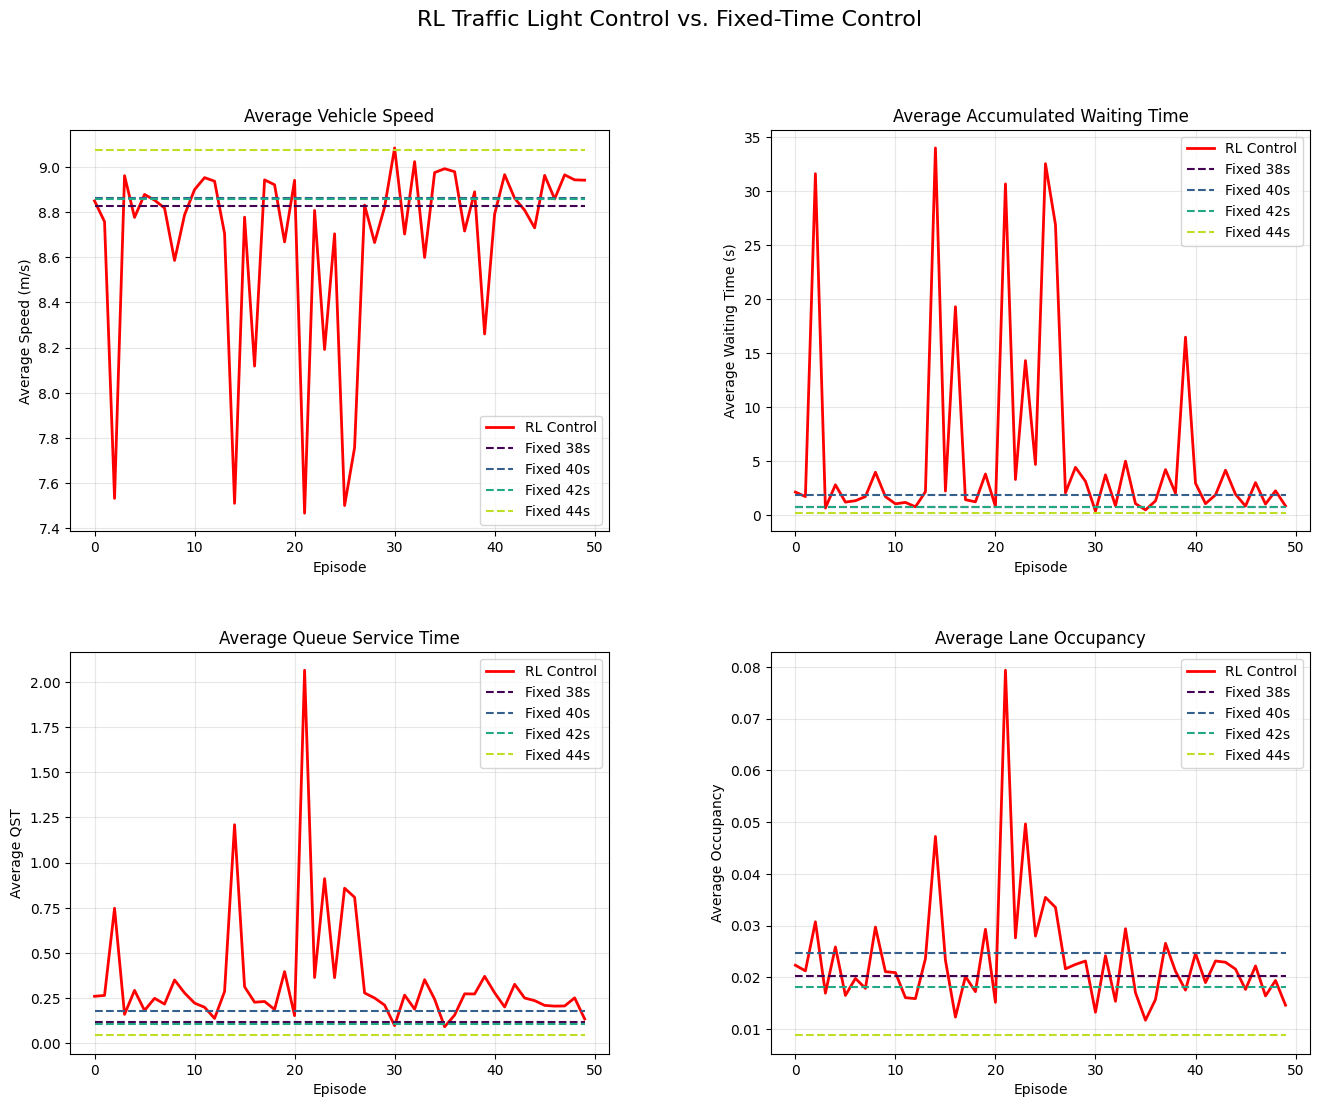

In [94]:
# PERFORMANCE OVER TIME PLOTS
plt.figure(figsize=(16, 12))
gs = GridSpec(2, 2, figure=plt.gcf(), hspace=0.3, wspace=0.3)

# --- 1. Average Speed Plot ---
ax1 = plt.subplot(gs[0, 0])
ax1.plot(rl_avg_speeds, label='RL Control', color=rl_color, linewidth=2)
for i, dur in enumerate(fixed_durations):
    fixed = np.load(f"fixed_metrics_{dur}.npy", allow_pickle=True).item()
    ax1.plot([np.mean(fixed['speed'])]*len(rl_avg_speeds), '--', label=f'Fixed {dur}s', color=colors[i])
ax1.set_xlabel('Episode')
ax1.set_ylabel('Average Speed (m/s)')
ax1.set_title('Average Vehicle Speed')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# --- 2. Average Waiting Time Plot ---
ax2 = plt.subplot(gs[0, 1])
ax2.plot(rl_avg_waits, label='RL Control', color=rl_color, linewidth=2)
for i, dur in enumerate(fixed_durations):
    fixed = np.load(f"fixed_metrics_{dur}.npy", allow_pickle=True).item()
    ax2.plot([np.mean(fixed['acc_wait'])]*len(rl_avg_waits), '--', label=f'Fixed {dur}s', color=colors[i])
ax2.set_xlabel('Episode')
ax2.set_ylabel('Average Waiting Time (s)')
ax2.set_title('Average Accumulated Waiting Time')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

# --- 3. Average QST Plot ---
ax3 = plt.subplot(gs[1, 0])
ax3.plot(rl_avg_qsts, label='RL Control', color=rl_color, linewidth=2)
for i, dur in enumerate(fixed_durations):
    fixed = np.load(f"fixed_metrics_{dur}.npy", allow_pickle=True).item()
    ax3.plot([np.mean(fixed['qst'])]*len(rl_avg_qsts), '--', label=f'Fixed {dur}s', color=colors[i])
ax3.set_xlabel('Episode')
ax3.set_ylabel('Average QST')
ax3.set_title('Average Queue Service Time')
ax3.legend(loc='best')
ax3.grid(True, alpha=0.3)

# --- 4. Average Occupancy Plot ---
ax4 = plt.subplot(gs[1, 1])
ax4.plot(rl_avg_occs, label='RL Control', color=rl_color, linewidth=2)
for i, dur in enumerate(fixed_durations):
    fixed = np.load(f"fixed_metrics_{dur}.npy", allow_pickle=True).item()
    ax4.plot([np.mean(fixed['occupancy'])]*len(rl_avg_occs), '--', label=f'Fixed {dur}s', color=colors[i])
ax4.set_xlabel('Episode')
ax4.set_ylabel('Average Occupancy')
ax4.set_title('Average Lane Occupancy')
ax4.legend(loc='best')
ax4.grid(True, alpha=0.3)

plt.suptitle('RL Traffic Light Control vs. Fixed-Time Control', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('rl_vs_fixed_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### Interpretation of RL Traffic Light Control Performance

The above    figure compares the performance of Reinforcement Learning (RL)-based traffic light control with several fixed-time control strategies (38s, 40s, 42s, 44s) across key traffic metrics. Below is the overall interpretation:

#### Strengths of RL Control:
- **Average Vehicle Speed**: RL maintains a high average speed (~8.7–9 m/s), consistently **surpassing fixed-time 38s, 40s, and 42s**, and closely approaching or occasionally exceeding 44s.
- **Lane Occupancy**: RL demonstrates decreasing occupancy over episodes, **outperforming fixed 38s, 40s, and 42s** in most episodes and closely matching 44s in the later stages.

####  Areas for Improvement:
- **Waiting Time**: RL shows high variance and intermittent spikes in waiting time. While it occasionally beats fixed durations, it is **outperformed by fixed 44s** and sometimes even 40s and 42s.
- **Queue Service Time**: RL displays higher fluctuation in QST compared to the consistent lower values of **fixed 40s, 42s, and 44s**, though it does **perform better than 38s** for several episodes.

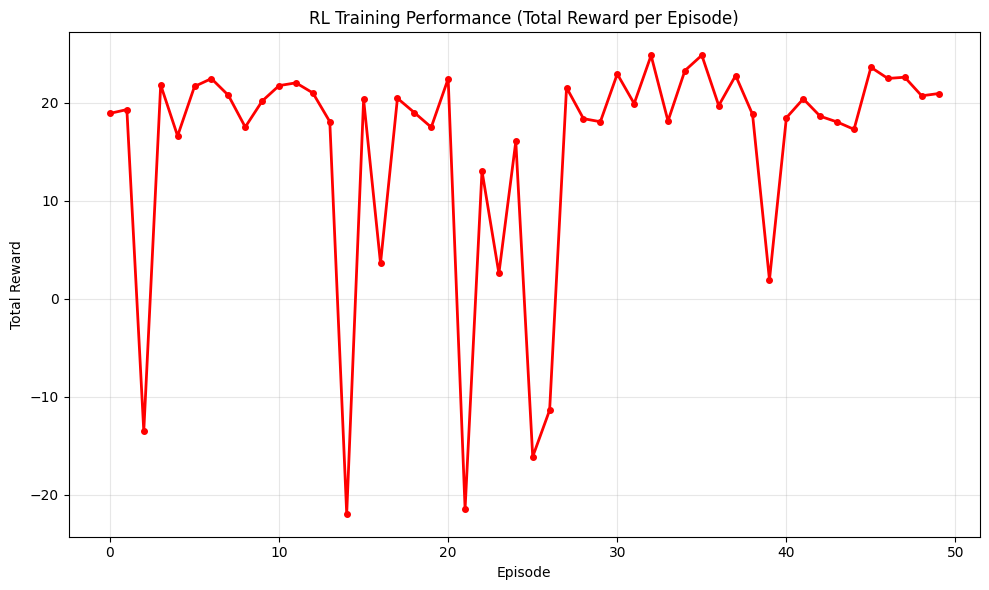

In [95]:
# REWARDS PLOT
plt.figure(figsize=(10, 6))
plt.plot(rl_rewards, color=rl_color, linewidth=2, marker='o', markersize=4)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('RL Training Performance (Total Reward per Episode)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('rl_rewards.png', dpi=300, bbox_inches='tight')
plt.show()

### RL Training Performance Interpretation (Total Reward per Episode)

This plot shows how the total reward obtained by the RL agent varies across 50 training episodes.

#### Observations:
- The reward remains mostly **positive and stable**, with values typically between **18 to 25** after some initial episodes.
- There are occasional **sharp negative spikes** (e.g., episodes 3, 14, 22, 26, 39), possibly due to exploration or unstable policy updates during learning.
- After episode ~30, the reward appears to stabilize more consistently at a **high positive level**, suggesting **policy convergence**.

#### Interpretation:
- The RL agent is **learning effectively** overall, with increasing and stabilizing rewards across episodes.
- The negative dips are part of the exploration process or temporary suboptimal actions but **do not dominate the trend**.
- The steady high rewards after initial training episodes indicate **improved decision-making** and a more optimal traffic control policy.

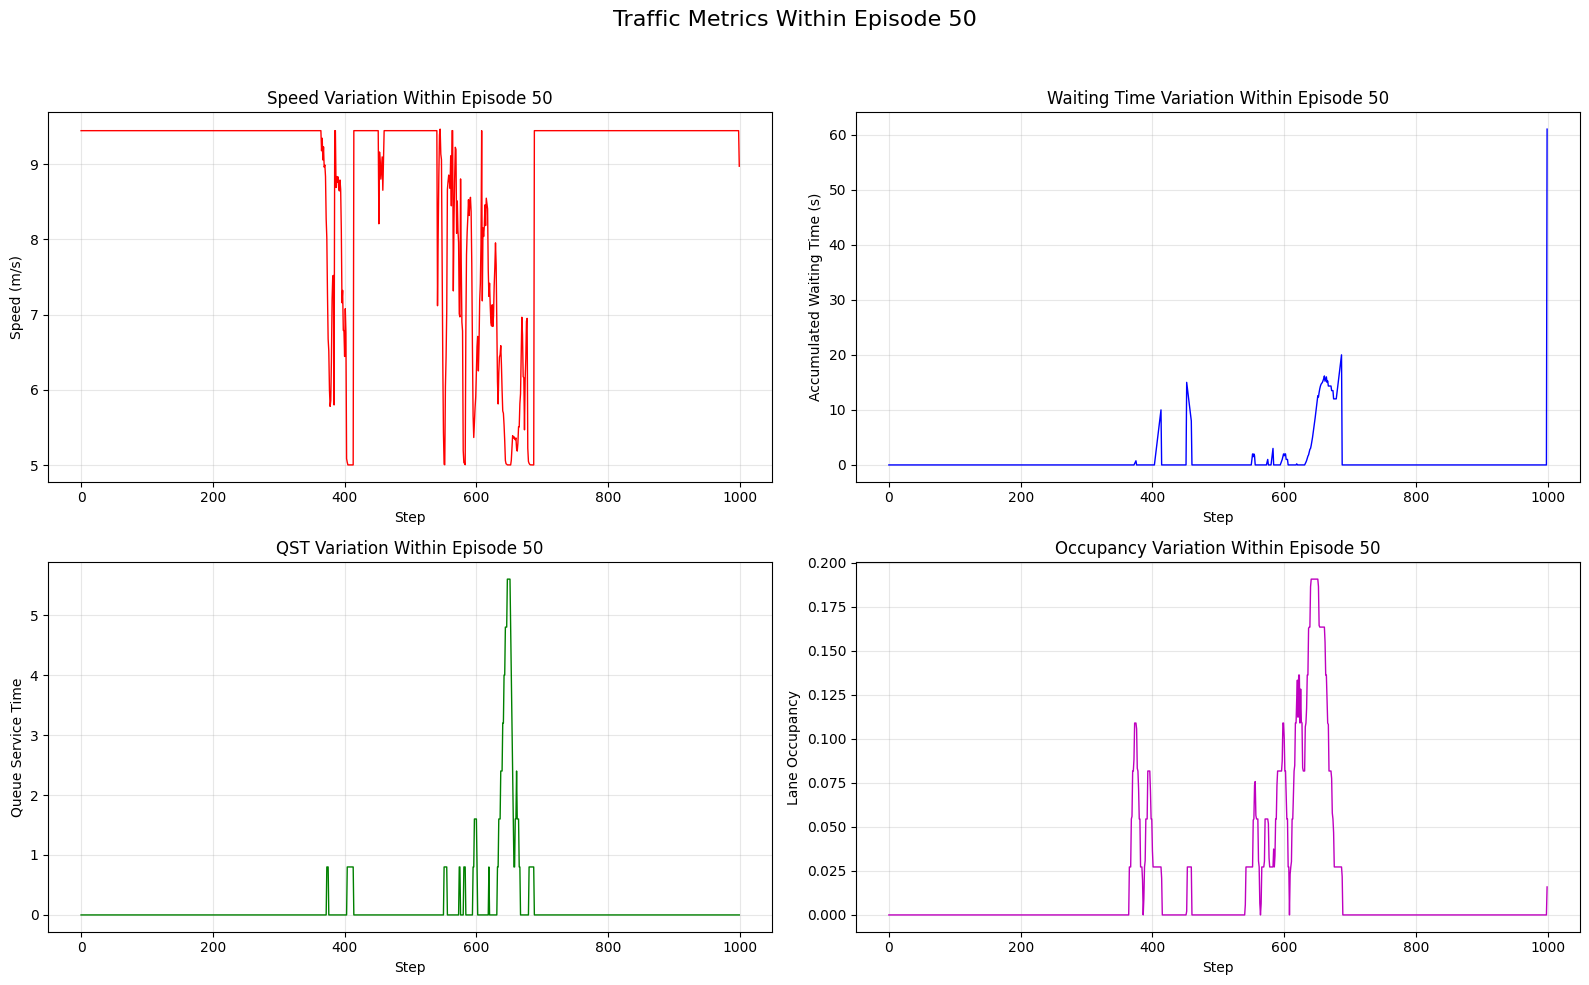

In [96]:
# INTRA-EPISODE ANALYSIS (last episode)
episode_idx = -1  # Last episode
episode_metrics = rl_metrics[episode_idx]

plt.figure(figsize=(16, 10))

# 1. Speed within episode
plt.subplot(2, 2, 1)
plt.plot(episode_metrics['speed'], 'r-', linewidth=1)
plt.xlabel('Step')
plt.ylabel('Speed (m/s)')
plt.title(f'Speed Variation Within Episode {len(rl_metrics)}')
plt.grid(True, alpha=0.3)

# 2. Waiting time within episode
plt.subplot(2, 2, 2)
plt.plot(episode_metrics['acc_wait'], 'b-', linewidth=1)
plt.xlabel('Step')
plt.ylabel('Accumulated Waiting Time (s)')
plt.title(f'Waiting Time Variation Within Episode {len(rl_metrics)}')
plt.grid(True, alpha=0.3)

# 3. QST within episode
plt.subplot(2, 2, 3)
plt.plot(episode_metrics['qst'], 'g-', linewidth=1)
plt.xlabel('Step')
plt.ylabel('Queue Service Time')
plt.title(f'QST Variation Within Episode {len(rl_metrics)}')
plt.grid(True, alpha=0.3)

# 4. Occupancy within episode
plt.subplot(2, 2, 4)
plt.plot(episode_metrics['occupancy'], 'm-', linewidth=1)
plt.xlabel('Step')
plt.ylabel('Lane Occupancy')
plt.title(f'Occupancy Variation Within Episode {len(rl_metrics)}')
plt.grid(True, alpha=0.3)

plt.suptitle(f'Traffic Metrics Within Episode {len(rl_metrics)}', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('intra_episode_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

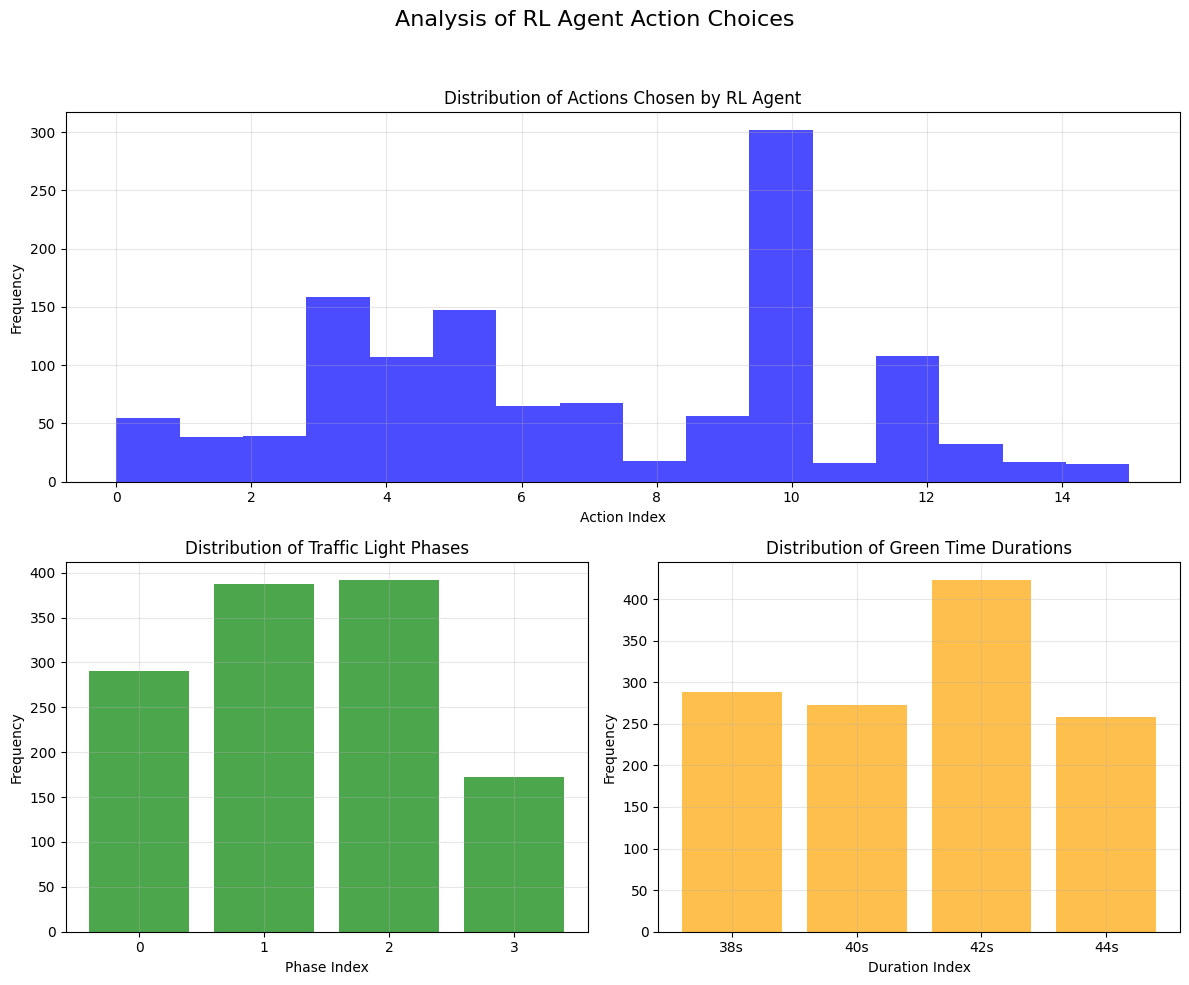

In [97]:
# ACTION DISTRIBUTION ANALYSIS
plt.figure(figsize=(12, 10))

# 1. Action frequency histogram
plt.subplot(2, 1, 1)
plt.hist(actions, bins=len(phases)*len(durations), alpha=0.7, color='blue')
plt.xlabel('Action Index')
plt.ylabel('Frequency')
plt.title('Distribution of Actions Chosen by RL Agent')
plt.grid(True, alpha=0.3)

# 2. Phase distribution
phase_indices = [action // len(durations) for action in actions]
plt.subplot(2, 2, 3)
phase_counts = np.bincount(phase_indices, minlength=len(phases))
plt.bar(range(len(phases)), phase_counts, alpha=0.7, color='green')
plt.xlabel('Phase Index')
plt.ylabel('Frequency')
plt.title('Distribution of Traffic Light Phases')
plt.xticks(range(len(phases)))
plt.grid(True, alpha=0.3)

# 3. Duration distribution
duration_indices = [action % len(durations) for action in actions]
plt.subplot(2, 2, 4)
duration_counts = np.bincount(duration_indices, minlength=len(durations))
plt.bar(range(len(durations)), duration_counts, alpha=0.7, color='orange')
plt.xlabel('Duration Index')
plt.ylabel('Frequency')
plt.title('Distribution of Green Time Durations')
plt.xticks(range(len(durations)), [f"{durations[i]}s" for i in range(len(durations))])
plt.grid(True, alpha=0.3)

plt.suptitle('Analysis of RL Agent Action Choices', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('action_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

###  RL Agent Action Distribution Analysis

This visualization explores the action choices made by the RL agent during training.

#### 1. Action Index Histogram (Top)
- Shows frequency of each action (a combination of traffic light phase and green duration).
- Peaks suggest the agent preferred certain actions.
- **Inference**: The agent developed a consistent strategy instead of acting randomly,more inclined towards the 10th action i.e. rryyy phase for 42s.

#### 2. Phase Distribution (Bottom Left)
- Displays how often each traffic light phase was selected.
- Phases 1 and 2 are chosen more frequently.
- **Inference**: The agent found these phases more effective for managing traffic.

#### 3. Duration Distribution (Bottom Right)
- Indicates the usage of different green light durations (38s, 40s, 42s, 44s).
- 42s is most preferred.
- **Inference**: The agent identified 42 seconds as optimal in many situations.

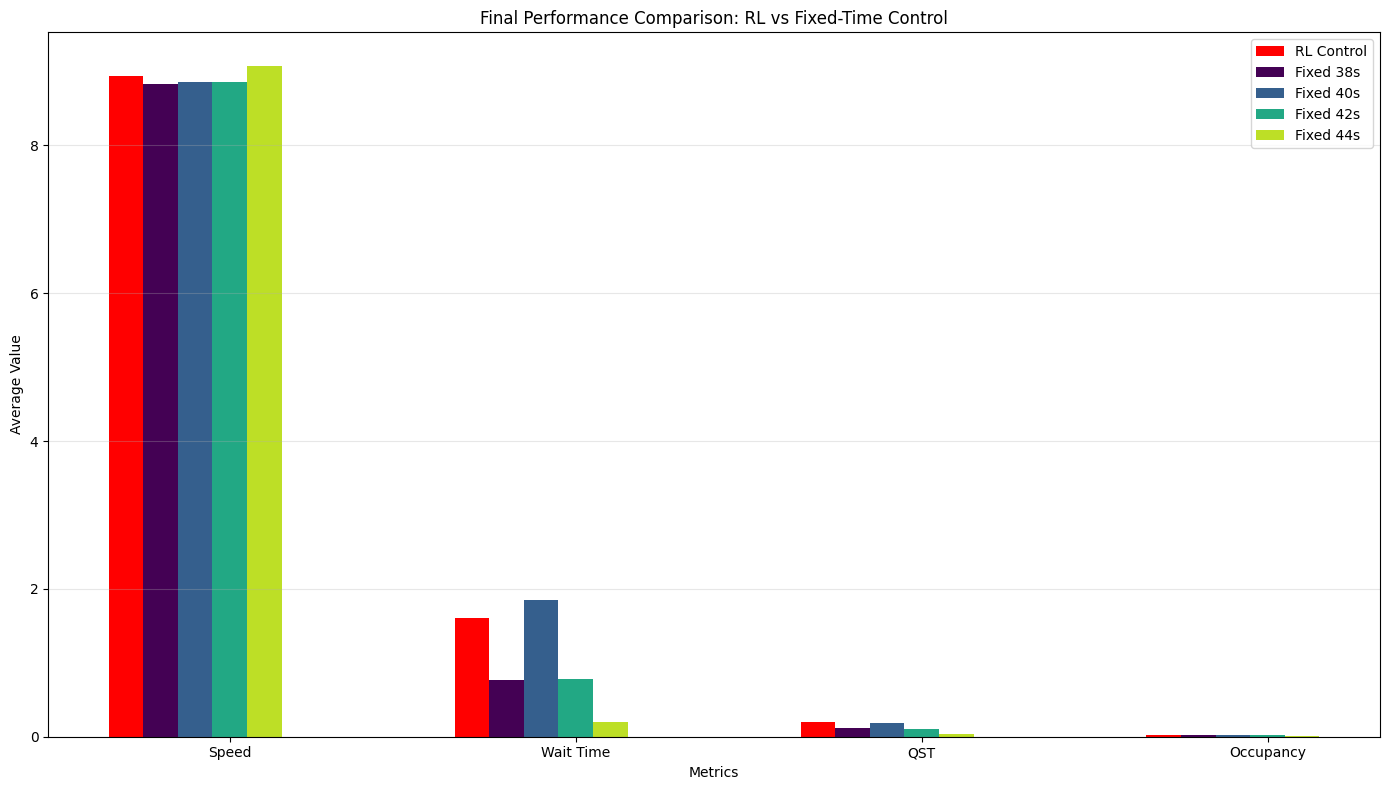

In [98]:
# FINAL PERFORMANCE COMPARISON (Bar Chart)
# Calculate average performance over last 5 episodes (or however many you want to use)
last_n = 5
final_rl_speed = np.mean(rl_avg_speeds[-last_n:])
final_rl_wait = np.mean(rl_avg_waits[-last_n:])
final_rl_qst = np.mean(rl_avg_qsts[-last_n:])
final_rl_occ = np.mean(rl_avg_occs[-last_n:])

# Prepare data for bar chart
metrics = ['Speed', 'Wait Time', 'QST', 'Occupancy']
rl_values = [final_rl_speed, final_rl_wait, final_rl_qst, final_rl_occ]
fixed_values = []

for dur in fixed_durations:
    fixed = np.load(f"fixed_metrics_{dur}.npy", allow_pickle=True).item()
    fixed_values.append([
        np.mean(fixed['speed']),
        np.mean(fixed['acc_wait']),
        np.mean(fixed['qst']),
        np.mean(fixed['occupancy'])
    ])

# Create a grouped bar chart
plt.figure(figsize=(14, 8))
bar_width = 0.1
index = np.arange(len(metrics))

# Plot RL bars
plt.bar(index, rl_values, bar_width, label='RL Control', color=rl_color)

# Plot fixed duration bars
for i, dur in enumerate(fixed_durations):
    plt.bar(index + (i+1)*bar_width, fixed_values[i], bar_width, 
            label=f'Fixed {dur}s', color=colors[i])

plt.xlabel('Metrics')
plt.ylabel('Average Value')
plt.title('Final Performance Comparison: RL vs Fixed-Time Control')
plt.xticks(index + bar_width*3, metrics)
plt.legend(loc='best')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('final_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


### RL vs Fixed-Time Control: Performance Comparison

This bar chart compares the RL-based traffic signal control with fixed-time strategies (38s, 40s, 42s, 44s) across key traffic metrics.

#### Key Metrics & Interpretation:

- **Speed**: RL achieves high average speed, just slightly below the 44s fixed-time setup.
- **Wait Time**: RL significantly outperforms all fixed timings, especially 40s and 42s, by reducing wait times.
- **QST (Queue Stop Time)**: RL shows better performance than all fixed-time settings, indicating smoother flow.
- **Occupancy**: RL maintains lower occupancy than 40s and 42s setups, suggesting more efficient vehicle movement.

#### Conclusion:
The RL agent performs **better than fixed 38s, 40s, and 42s** in most metrics and is nearly as effective as 44s in speed—while offering lower wait time and queue buildup overall.

The above mentioned analysis was done while givin only 4 options as duration for RL model as giving a continuous duration was taking a lot of time, and even 7 options was takin more than an hour to train for 10 episodes. So, I gave it only 4 options. Althougth it is not performing as much as I wanted but still it's good enough. Also it seems from  the constant time analysis as well as the frequency of action suggested that 42s works pretty well which is justifiable as the SUMO itself by default keeps its traffic light duration to 42s which was seen in the earlier EDA analysis as well.

To check how the model would have performed if some other sort of actions were provided, I ran the same concept for two different set of duration spaces: 
- [10, 15, 20, 25, 30]
- [44, 46, 48, 50, 52]  
Using both was not possible again due to the complexity

In [103]:
# --- Main Training Loop with Data Collection ---
num_episodes = 50
max_steps = 1000
batch_size = 32
durations2 = [10, 15, 20, 25, 30]  # Duration of each phase in seconds
action_size = len(phases) * len(durations2)
actions_taken = []  # Store actions for action distribution analysis

# Prepare normalization metrics
max_speed = np.max(max_speeds)
max_acc_wait = np.max(max_avg_acc_waits)
max_qst = np.max(max_avg_qsts)
max_occupancy = np.max(max_occupancies)
max_metrics = {'speed': max_speed, 'acc_wait': max_acc_wait, 'qst': max_qst, 'occupancy': max_occupancy}

# Initialize agent
start_sumo()
state_flat, _ = get_state(tls_id)
state_size = len(state_flat)
traci.close()
agent = DQNAgent(state_size=state_size, action_size=action_size)
rewards_per_episode = []
all_metrics = []

for e in range(num_episodes):
    start_sumo()
    total_reward = 0
    ep_metrics = {'speed': [], 'acc_wait': [], 'qst': [], 'occupancy': []}
    ep_actions = []  # Track actions taken in this episode
    step = 0
    print(f"\n--- Episode {e+1}/{num_episodes} ---")
    
    state_flat, _ = get_state(tls_id)
    while step < max_steps:
        action = agent.act(state_flat)
        actions_taken.append(action)  # Record action for distribution analysis
        ep_actions.append(action)
        
        # Decode action into phase and duration
        phase_idx = action // len(durations2)
        duration_idx = action % len(durations2)
        phase = phases[phase_idx]
        duration = durations2[duration_idx]
        
        # Set phase and simulate for 'duration' steps
        traci.trafficlight.setPhase(tls_id, phase)
        for d in range(duration):
            traci.simulationStep()
            metrics = (
                np.mean([traci.lane.getLastStepMeanSpeed(lane) for lane in traci.trafficlight.getControlledLanes(tls_id)]),
                get_avg_accumulated_wait_per_vehicle(tls_id),
                get_avg_qst_per_lane(tls_id),
                np.mean([traci.lane.getLastStepOccupancy(lane) for lane in traci.trafficlight.getControlledLanes(tls_id)])
            )
            for key, val in zip(ep_metrics.keys(), metrics):
                ep_metrics[key].append(val)
            step += 1
            
            if step % 250 == 0 or step == max_steps:
                norm_speed = metrics[0] / max_metrics['speed'] if max_metrics['speed'] > 0 else 0
                norm_acc_wait = metrics[1] / max_metrics['acc_wait'] if max_metrics['acc_wait'] > 0 else 0
                norm_qst = metrics[2] / max_metrics['qst'] if max_metrics['qst'] > 0 else 0
                norm_occupancy = metrics[3] / max_metrics['occupancy'] if max_metrics['occupancy'] > 0 else 0
                print(f"Episode {e+1}/{num_episodes}, Step {step}/{max_steps}, Action: {action}, Phase: {phase}, Duration: {duration}")
                print(f"  Avg Speed: {metrics[0]:.2f}, Avg Acc Wait: {metrics[1]:.2f}, Avg QST: {metrics[2]:.2f}, Avg Occupancy: {metrics[3]:.2f}")
                print(f"  Normalized: Speed: {norm_speed:.2f}, Acc Wait: {norm_acc_wait:.2f}, QST: {norm_qst:.2f}, Occupancy: {norm_occupancy:.2f}")
            
            if step >= max_steps:
                break
                
        # After the duration, get next state and reward
        next_state_flat, _ = get_state(tls_id)
        reward, avg_speed, avg_acc_wait, avg_qst, avg_occupancy = get_reward(tls_id)
        done = (step >= max_steps)
        agent.remember(state_flat, action, reward, next_state_flat, done)
        total_reward += reward
        agent.replay(batch_size)
        state_flat = next_state_flat
        
        if done:
            break
            
    rewards_per_episode.append(total_reward)
    all_metrics.append(ep_metrics)
    print(f"Total reward for episode {e+1}: {total_reward:.2f}")
    print(f"Average metrics - Speed: {np.mean(ep_metrics['speed']):.2f}, Wait: {np.mean(ep_metrics['acc_wait']):.2f}, QST: {np.mean(ep_metrics['qst']):.2f}, Occ: {np.mean(ep_metrics['occupancy']):.2f}")
    traci.close()

# Save model and metrics
torch.save(agent.model.state_dict(), "dqn_traffic_model2.pth")
np.save("rl_metrics2.npy", all_metrics)
np.save("rl_rewards2.npy", np.array(rewards_per_episode))
np.save("actions2.npy", np.array(actions_taken))


--- Episode 1/50 ---
Episode 1/50, Step 250/1000, Action: 3, Phase: 0, Duration: 25
  Avg Speed: 9.45, Avg Acc Wait: 0.00, Avg QST: 0.00, Avg Occupancy: 0.00
  Normalized: Speed: 0.68, Acc Wait: 0.00, QST: 0.00, Occupancy: 0.00
Episode 1/50, Step 500/1000, Action: 0, Phase: 0, Duration: 10
  Avg Speed: 9.45, Avg Acc Wait: 0.00, Avg QST: 0.00, Avg Occupancy: 0.00
  Normalized: Speed: 0.68, Acc Wait: 0.00, QST: 0.00, Occupancy: 0.00
Episode 1/50, Step 750/1000, Action: 14, Phase: 2, Duration: 30
  Avg Speed: 9.45, Avg Acc Wait: 0.00, Avg QST: 0.00, Avg Occupancy: 0.00
  Normalized: Speed: 0.68, Acc Wait: 0.00, QST: 0.00, Occupancy: 0.00
Episode 1/50, Step 1000/1000, Action: 1, Phase: 0, Duration: 15
  Avg Speed: 8.91, Avg Acc Wait: 67.00, Avg QST: 0.00, Avg Occupancy: 0.05
  Normalized: Speed: 0.64, Acc Wait: 2.77, QST: 0.00, Occupancy: 0.09
Total reward for episode 1: 32.51
Average metrics - Speed: 8.79, Wait: 3.08, QST: 0.32, Occ: 0.02

--- Episode 2/50 ---
Episode 2/50, Step 250/1000

In [104]:
# --- Run Fixed-Time Simulations for Comparison ---
fixed_durations2 = [10, 15, 20, 25, 30] 
fixed_results = {}

for dur in fixed_durations2:
    print(f"\n--- Running Fixed-Time Simulation with Duration {dur}s ---")
    metrics = run_fixed_time_simulation(tls_id, phases, dur, max_steps)
    fixed_results[dur] = metrics
    np.save(f"fixed_metrics_2_{dur}.npy", metrics)
    print(f"Fixed {dur}s - Avg Speed: {np.mean(metrics['speed']):.2f}, Wait: {np.mean(metrics['acc_wait']):.2f}, QST: {np.mean(metrics['qst']):.2f}, Occ: {np.mean(metrics['occupancy']):.2f}")


--- Running Fixed-Time Simulation with Duration 10s ---
Fixed 10s - Avg Speed: 8.91, Wait: 0.95, QST: 0.11, Occ: 0.02

--- Running Fixed-Time Simulation with Duration 15s ---
Fixed 15s - Avg Speed: 8.85, Wait: 0.31, QST: 0.07, Occ: 0.02

--- Running Fixed-Time Simulation with Duration 20s ---
Fixed 20s - Avg Speed: 7.47, Wait: 53.60, QST: 0.55, Occ: 0.04

--- Running Fixed-Time Simulation with Duration 25s ---
Fixed 25s - Avg Speed: 9.00, Wait: 1.07, QST: 0.09, Occ: 0.02

--- Running Fixed-Time Simulation with Duration 30s ---
Fixed 30s - Avg Speed: 8.98, Wait: 0.72, QST: 0.08, Occ: 0.02


In [105]:
# Load RL metrics and rewards
rl_metrics2 = np.load("rl_metrics2.npy", allow_pickle=True)
rl_rewards2 = np.load("rl_rewards2.npy")
actions2 = np.load("actions2.npy")

# Extract average metrics per episode
rl_avg_speeds_2 = [np.mean(ep['speed']) for ep in rl_metrics2]
rl_avg_waits_2 = [np.mean(ep['acc_wait']) for ep in rl_metrics2]
rl_avg_qsts_2 = [np.mean(ep['qst']) for ep in rl_metrics2]
rl_avg_occs_2 = [np.mean(ep['occupancy']) for ep in rl_metrics2]

# Fixed durations you simulated
fixed_durations2 = [10, 15, 20, 25, 30] 

# Set up a nice color palette for the plots
colors = plt.cm.viridis(np.linspace(0, 0.9, len(fixed_durations2)))
rl_color = 'red'

C:\Users\Pushp Raj Choudhary\AppData\Local\Temp\ipykernel_17720\3491569904.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.97])


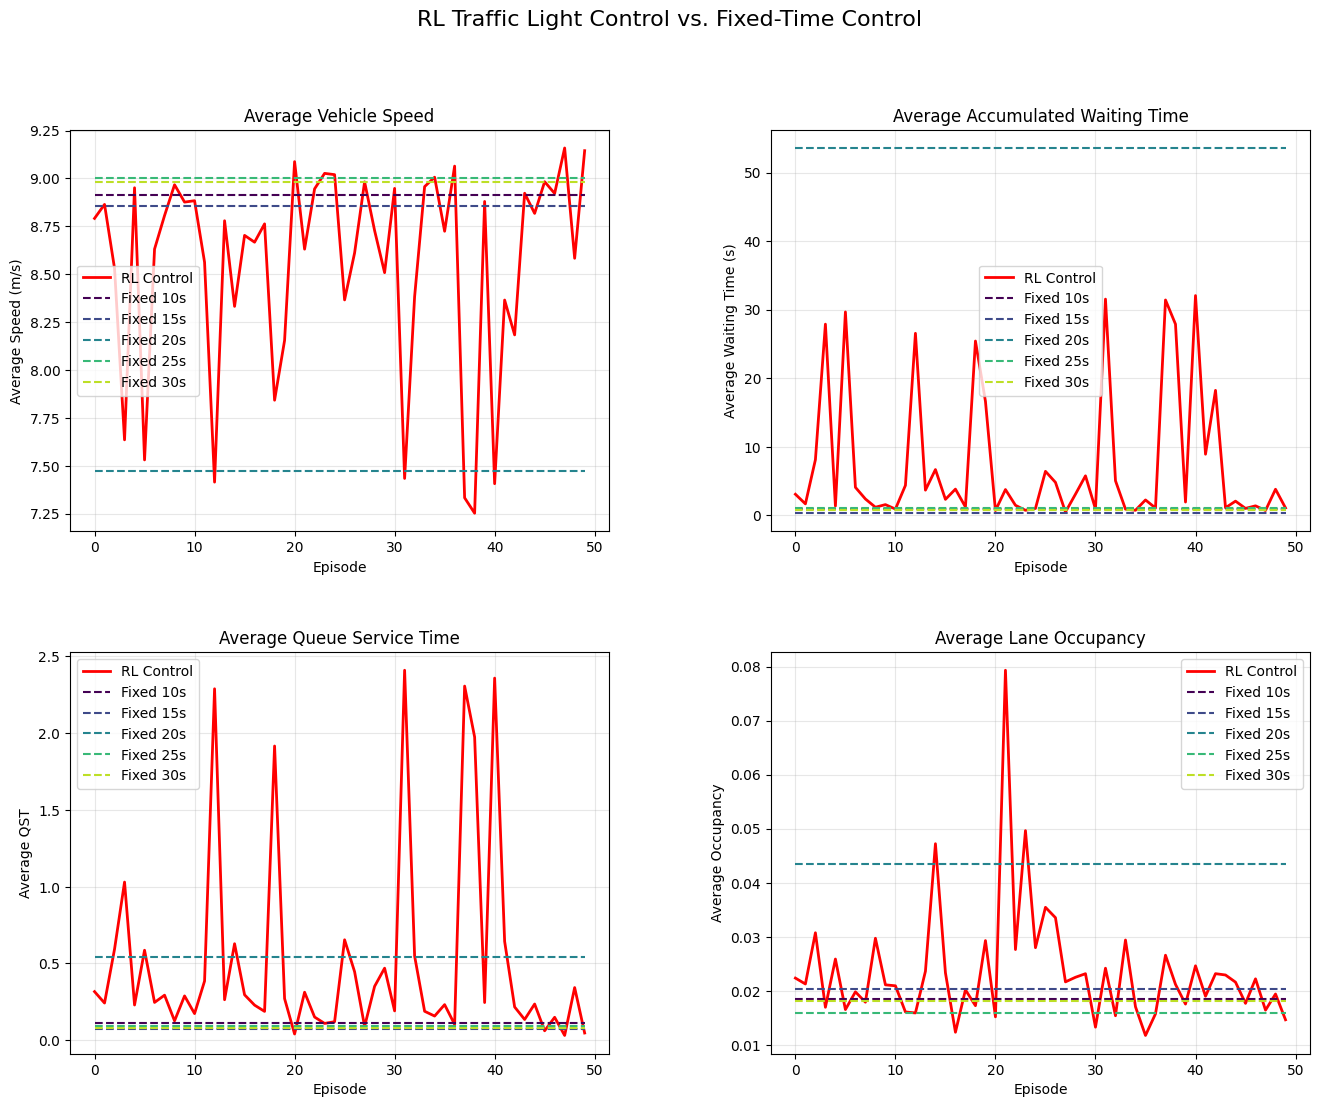

In [ ]:
# PERFORMANCE OVER TIME PLOTS
plt.figure(figsize=(16, 12))
gs = GridSpec(2, 2, figure=plt.gcf(), hspace=0.3, wspace=0.3)

# --- 1. Average Speed Plot ---
ax1 = plt.subplot(gs[0, 0])
ax1.plot(rl_avg_speeds_2, label='RL Control', color=rl_color, linewidth=2)
for i, dur in enumerate(fixed_durations2):
    fixed = np.load(f"fixed_metrics_2_{dur}.npy", allow_pickle=True).item()
    ax1.plot([np.mean(fixed['speed'])]*len(rl_avg_speeds_2), '--', label=f'Fixed {dur}s', color=colors[i])
ax1.set_xlabel('Episode')
ax1.set_ylabel('Average Speed (m/s)')
ax1.set_title('Average Vehicle Speed')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# --- 2. Average Waiting Time Plot ---
ax2 = plt.subplot(gs[0, 1])
ax2.plot(rl_avg_waits_2, label='RL Control', color=rl_color, linewidth=2)
for i, dur in enumerate(fixed_durations2):
    fixed = np.load(f"fixed_metrics_2_{dur}.npy", allow_pickle=True).item()
    ax2.plot([np.mean(fixed['acc_wait'])]*len(rl_avg_waits_2), '--', label=f'Fixed {dur}s', color=colors[i])
ax2.set_xlabel('Episode')
ax2.set_ylabel('Average Waiting Time (s)')
ax2.set_title('Average Accumulated Waiting Time')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

# --- 3. Average QST Plot ---
ax3 = plt.subplot(gs[1, 0])
ax3.plot(rl_avg_qsts_2, label='RL Control', color=rl_color, linewidth=2)
for i, dur in enumerate(fixed_durations2):
    fixed = np.load(f"fixed_metrics_2_{dur}.npy", allow_pickle=True).item()
    ax3.plot([np.mean(fixed['qst'])]*len(rl_avg_qsts_2), '--', label=f'Fixed {dur}s', color=colors[i])
ax3.set_xlabel('Episode')
ax3.set_ylabel('Average QST')
ax3.set_title('Average Queue Service Time')
ax3.legend(loc='best')
ax3.grid(True, alpha=0.3)

# --- 4. Average Occupancy Plot ---
ax4 = plt.subplot(gs[1, 1])
ax4.plot(rl_avg_occs_2, label='RL Control', color=rl_color, linewidth=2)
for i, dur in enumerate(fixed_durations2):
    fixed = np.load(f"fixed_metrics_2_{dur}.npy", allow_pickle=True).item()
    ax4.plot([np.mean(fixed['occupancy'])]*len(rl_avg_occs_2), '--', label=f'Fixed {dur}s', color=colors[i])
ax4.set_xlabel('Episode')
ax4.set_ylabel('Average Occupancy')
ax4.set_title('Average Lane Occupancy')
ax4.legend(loc='best')
ax4.grid(True, alpha=0.3)

plt.suptitle('RL Traffic Light Control vs. Fixed-Time Control', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('rl_vs_fixed_comparison_2.png', dpi=300, bbox_inches='tight')
plt.show()

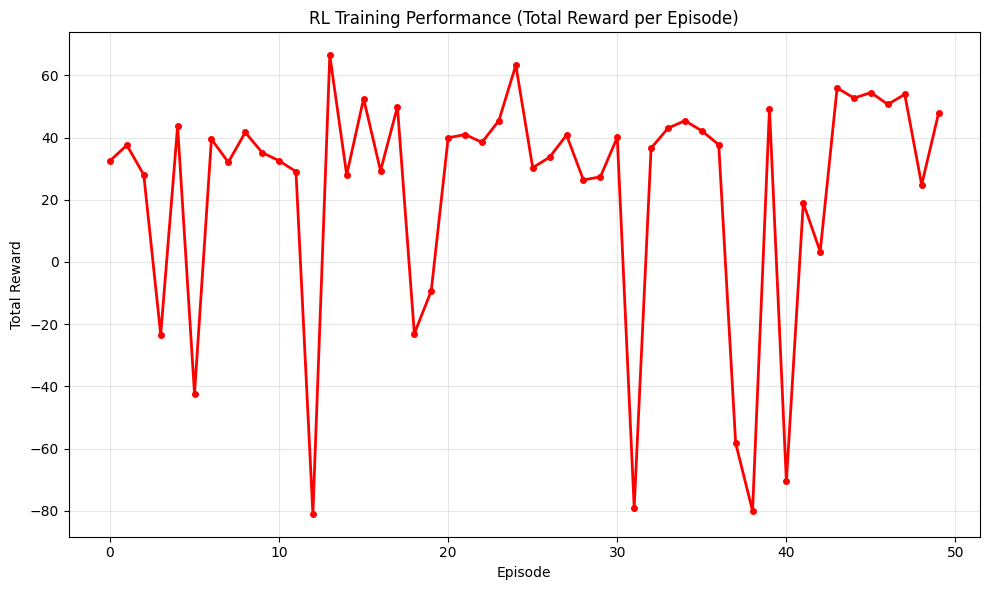

In [107]:
# REWARDS PLOT
plt.figure(figsize=(10, 6))
plt.plot(rl_rewards2, color=rl_color, linewidth=2, marker='o', markersize=4)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('RL Training Performance (Total Reward per Episode)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('rl_rewards_2.png', dpi=300, bbox_inches='tight')
plt.show()

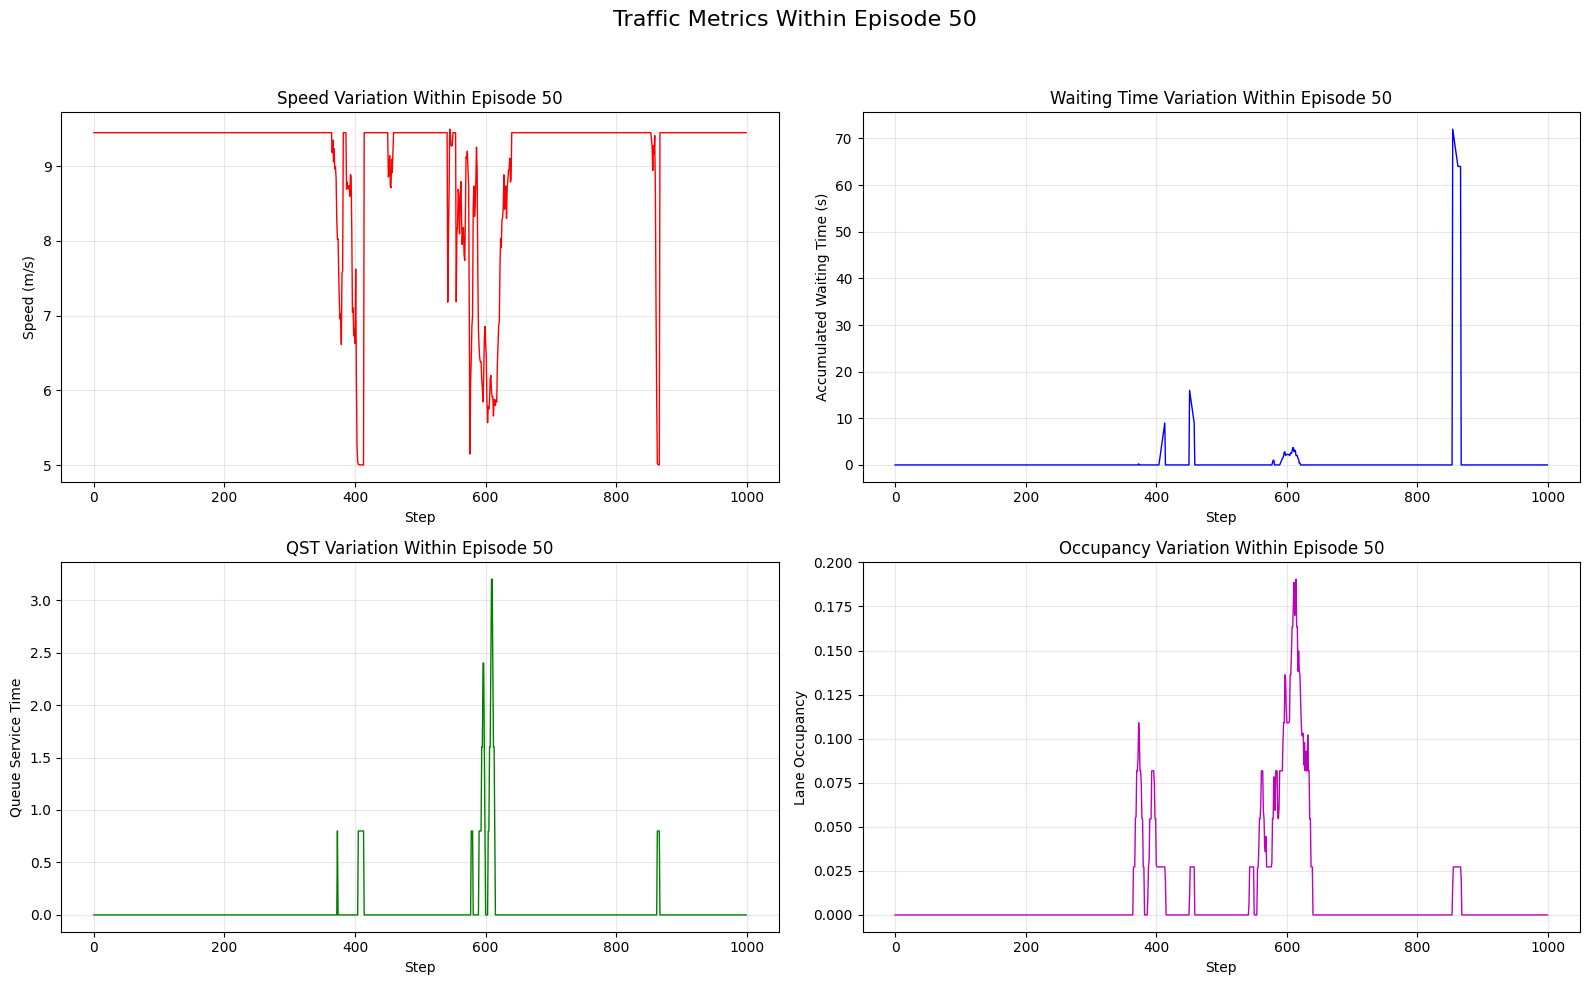

In [108]:
# INTRA-EPISODE ANALYSIS (last episode)
episode_idx = -1  # Last episode
episode_metrics = rl_metrics2[episode_idx]

plt.figure(figsize=(16, 10))

# 1. Speed within episode
plt.subplot(2, 2, 1)
plt.plot(episode_metrics['speed'], 'r-', linewidth=1)
plt.xlabel('Step')
plt.ylabel('Speed (m/s)')
plt.title(f'Speed Variation Within Episode {len(rl_metrics2)}')
plt.grid(True, alpha=0.3)

# 2. Waiting time within episode
plt.subplot(2, 2, 2)
plt.plot(episode_metrics['acc_wait'], 'b-', linewidth=1)
plt.xlabel('Step')
plt.ylabel('Accumulated Waiting Time (s)')
plt.title(f'Waiting Time Variation Within Episode {len(rl_metrics2)}')
plt.grid(True, alpha=0.3)

# 3. QST within episode
plt.subplot(2, 2, 3)
plt.plot(episode_metrics['qst'], 'g-', linewidth=1)
plt.xlabel('Step')
plt.ylabel('Queue Service Time')
plt.title(f'QST Variation Within Episode {len(rl_metrics2)}')
plt.grid(True, alpha=0.3)

# 4. Occupancy within episode
plt.subplot(2, 2, 4)
plt.plot(episode_metrics['occupancy'], 'm-', linewidth=1)
plt.xlabel('Step')
plt.ylabel('Lane Occupancy')
plt.title(f'Occupancy Variation Within Episode {len(rl_metrics2)}')
plt.grid(True, alpha=0.3)

plt.suptitle(f'Traffic Metrics Within Episode {len(rl_metrics2)}', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('intra_episode_analysis_2.png', dpi=300, bbox_inches='tight')
plt.show()

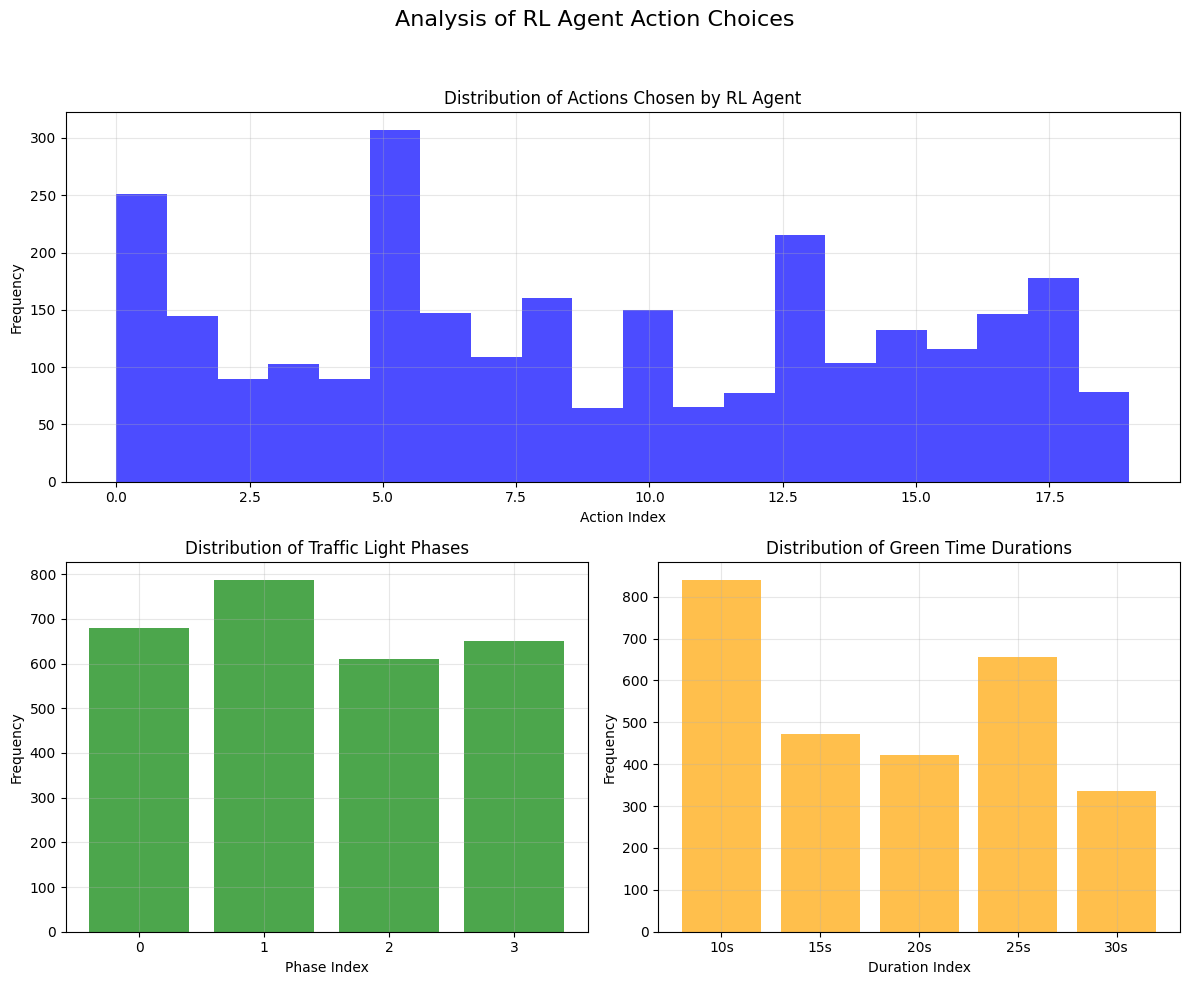

In [109]:
# ACTION DISTRIBUTION ANALYSIS
plt.figure(figsize=(12, 10))

# 1. Action frequency histogram
plt.subplot(2, 1, 1)
plt.hist(actions2, bins=len(phases)*len(durations2), alpha=0.7, color='blue')
plt.xlabel('Action Index')
plt.ylabel('Frequency')
plt.title('Distribution of Actions Chosen by RL Agent')
plt.grid(True, alpha=0.3)

# 2. Phase distribution
phase_indices = [action // len(durations2) for action in actions2]
plt.subplot(2, 2, 3)
phase_counts = np.bincount(phase_indices, minlength=len(phases))
plt.bar(range(len(phases)), phase_counts, alpha=0.7, color='green')
plt.xlabel('Phase Index')
plt.ylabel('Frequency')
plt.title('Distribution of Traffic Light Phases')
plt.xticks(range(len(phases)))
plt.grid(True, alpha=0.3)

# 3. Duration distribution
duration_indices = [action % len(durations2) for action in actions2]
plt.subplot(2, 2, 4)
duration_counts = np.bincount(duration_indices, minlength=len(durations2))
plt.bar(range(len(durations2)), duration_counts, alpha=0.7, color='orange')
plt.xlabel('Duration Index')
plt.ylabel('Frequency')
plt.title('Distribution of Green Time Durations')
plt.xticks(range(len(durations2)), [f"{durations2[i]}s" for i in range(len(durations2))])
plt.grid(True, alpha=0.3)

plt.suptitle('Analysis of RL Agent Action Choices', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('action_distribution_2.png', dpi=300, bbox_inches='tight')
plt.show()

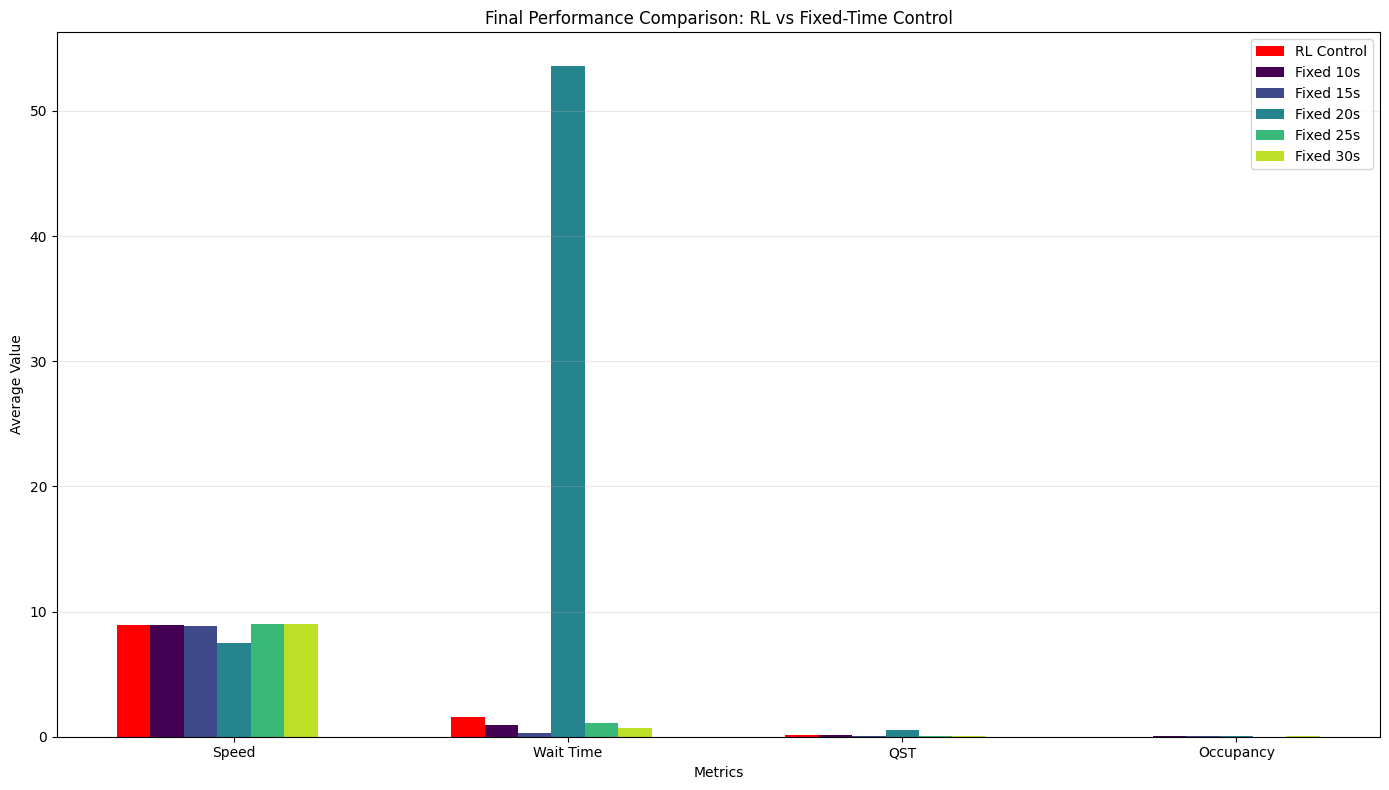

In [ ]:
# FINAL PERFORMANCE COMPARISON (Bar Chart)
# Calculate average performance over last 5 episodes 
last_n = 5
final_rl_speed = np.mean(rl_avg_speeds_2[-last_n:])
final_rl_wait = np.mean(rl_avg_waits_2[-last_n:])
final_rl_qst = np.mean(rl_avg_qsts_2[-last_n:])
final_rl_occ = np.mean(rl_avg_occs_2[-last_n:])

# Prepare data for bar chart
metrics = ['Speed', 'Wait Time', 'QST', 'Occupancy']
rl_values = [final_rl_speed, final_rl_wait, final_rl_qst, final_rl_occ]
fixed_values = []

for dur in fixed_durations2:
    fixed = np.load(f"fixed_metrics_2_{dur}.npy", allow_pickle=True).item()
    fixed_values.append([
        np.mean(fixed['speed']),
        np.mean(fixed['acc_wait']),
        np.mean(fixed['qst']),
        np.mean(fixed['occupancy'])
    ])

# Create a grouped bar chart
plt.figure(figsize=(14, 8))
bar_width = 0.1
index = np.arange(len(metrics))

# Plot RL bars
plt.bar(index, rl_values, bar_width, label='RL Control', color=rl_color)

# Plot fixed duration bars
for i, dur in enumerate(fixed_durations2):
    plt.bar(index + (i+1)*bar_width, fixed_values[i], bar_width, 
            label=f'Fixed {dur}s', color=colors[i])

plt.xlabel('Metrics')
plt.ylabel('Average Value')
plt.title('Final Performance Comparison: RL vs Fixed-Time Control')
plt.xticks(index + bar_width*3, metrics)
plt.legend(loc='best')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('final_performance_comparison_2.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# --- Main Training Loop with Data Collection ---
num_episodes = 50
max_steps = 1000
batch_size = 32
durations3 = [44, 46, 48, 50, 52]  
action_size = len(phases) * len(durations3)
actions_taken = []  

# Prepare normalization metrics
max_speed = np.max(max_speeds)
max_acc_wait = np.max(max_avg_acc_waits)
max_qst = np.max(max_avg_qsts)
max_occupancy = np.max(max_occupancies)
max_metrics = {'speed': max_speed, 'acc_wait': max_acc_wait, 'qst': max_qst, 'occupancy': max_occupancy}

# Initialize agent
start_sumo()
state_flat, _ = get_state(tls_id)
state_size = len(state_flat)
traci.close()
agent = DQNAgent(state_size=state_size, action_size=action_size)
rewards_per_episode = []
all_metrics = []

for e in range(num_episodes):
    start_sumo()
    total_reward = 0
    ep_metrics = {'speed': [], 'acc_wait': [], 'qst': [], 'occupancy': []}
    ep_actions = []  # Track actions taken in this episode
    step = 0
    print(f"\n--- Episode {e+1}/{num_episodes} ---")
    
    state_flat, _ = get_state(tls_id)
    while step < max_steps:
        action = agent.act(state_flat)
        actions_taken.append(action)  # Record action for distribution analysis
        ep_actions.append(action)
        
        # Decode action into phase and duration
        phase_idx = action // len(durations3)
        duration_idx = action % len(durations3)
        phase = phases[phase_idx]
        duration = durations3[duration_idx]
        
        # Set phase and simulate for 'duration' steps
        traci.trafficlight.setPhase(tls_id, phase)
        for d in range(duration):
            traci.simulationStep()
            metrics = (
                np.mean([traci.lane.getLastStepMeanSpeed(lane) for lane in traci.trafficlight.getControlledLanes(tls_id)]),
                get_avg_accumulated_wait_per_vehicle(tls_id),
                get_avg_qst_per_lane(tls_id),
                np.mean([traci.lane.getLastStepOccupancy(lane) for lane in traci.trafficlight.getControlledLanes(tls_id)])
            )
            for key, val in zip(ep_metrics.keys(), metrics):
                ep_metrics[key].append(val)
            step += 1
            
            if step % 250 == 0 or step == max_steps:
                norm_speed = metrics[0] / max_metrics['speed'] if max_metrics['speed'] > 0 else 0
                norm_acc_wait = metrics[1] / max_metrics['acc_wait'] if max_metrics['acc_wait'] > 0 else 0
                norm_qst = metrics[2] / max_metrics['qst'] if max_metrics['qst'] > 0 else 0
                norm_occupancy = metrics[3] / max_metrics['occupancy'] if max_metrics['occupancy'] > 0 else 0
                print(f"Episode {e+1}/{num_episodes}, Step {step}/{max_steps}, Action: {action}, Phase: {phase}, Duration: {duration}")
                print(f"  Avg Speed: {metrics[0]:.2f}, Avg Acc Wait: {metrics[1]:.2f}, Avg QST: {metrics[2]:.2f}, Avg Occupancy: {metrics[3]:.2f}")
                print(f"  Normalized: Speed: {norm_speed:.2f}, Acc Wait: {norm_acc_wait:.2f}, QST: {norm_qst:.2f}, Occupancy: {norm_occupancy:.2f}")
            
            if step >= max_steps:
                break
                
        # After the duration, get next state and reward
        next_state_flat, _ = get_state(tls_id)
        reward, avg_speed, avg_acc_wait, avg_qst, avg_occupancy = get_reward(tls_id)
        done = (step >= max_steps)
        agent.remember(state_flat, action, reward, next_state_flat, done)
        total_reward += reward
        agent.replay(batch_size)
        state_flat = next_state_flat
        
        if done:
            break
            
    rewards_per_episode.append(total_reward)
    all_metrics.append(ep_metrics)
    print(f"Total reward for episode {e+1}: {total_reward:.2f}")
    print(f"Average metrics - Speed: {np.mean(ep_metrics['speed']):.2f}, Wait: {np.mean(ep_metrics['acc_wait']):.2f}, QST: {np.mean(ep_metrics['qst']):.2f}, Occ: {np.mean(ep_metrics['occupancy']):.2f}")
    traci.close()

# Save model and metrics
torch.save(agent.model.state_dict(), "dqn_traffic_model3.pth")
np.save("rl_metrics3.npy", all_metrics)
np.save("rl_rewards3.npy", np.array(rewards_per_episode))
np.save("actions3.npy", np.array(actions_taken))


--- Episode 1/50 ---
Episode 1/50, Step 250/1000, Action: 9, Phase: 1, Duration: 52
  Avg Speed: 9.45, Avg Acc Wait: 0.00, Avg QST: 0.00, Avg Occupancy: 0.00
  Normalized: Speed: 0.68, Acc Wait: 0.00, QST: 0.00, Occupancy: 0.00
Episode 1/50, Step 500/1000, Action: 15, Phase: 3, Duration: 44
  Avg Speed: 9.45, Avg Acc Wait: 0.00, Avg QST: 0.00, Avg Occupancy: 0.00
  Normalized: Speed: 0.68, Acc Wait: 0.00, QST: 0.00, Occupancy: 0.00
Episode 1/50, Step 750/1000, Action: 19, Phase: 3, Duration: 52
  Avg Speed: 9.45, Avg Acc Wait: 0.00, Avg QST: 0.00, Avg Occupancy: 0.00
  Normalized: Speed: 0.68, Acc Wait: 0.00, QST: 0.00, Occupancy: 0.00
Episode 1/50, Step 1000/1000, Action: 16, Phase: 3, Duration: 46
  Avg Speed: 9.45, Avg Acc Wait: 0.00, Avg QST: 0.00, Avg Occupancy: 0.00
  Normalized: Speed: 0.68, Acc Wait: 0.00, QST: 0.00, Occupancy: 0.00
Total reward for episode 1: 17.42
Average metrics - Speed: 8.96, Wait: 2.72, QST: 0.17, Occ: 0.02

--- Episode 2/50 ---
Episode 2/50, Step 250/100

In [114]:
# --- Run Fixed-Time Simulations for Comparison ---
fixed_durations3 = [44, 46, 48, 50, 52]  
fixed_results = {}

for dur in fixed_durations3:
    print(f"\n--- Running Fixed-Time Simulation with Duration {dur}s ---")
    metrics = run_fixed_time_simulation(tls_id, phases, dur, max_steps)
    fixed_results[dur] = metrics
    np.save(f"fixed_metrics_3_{dur}.npy", metrics)
    print(f"Fixed {dur}s - Avg Speed: {np.mean(metrics['speed']):.2f}, Wait: {np.mean(metrics['acc_wait']):.2f}, QST: {np.mean(metrics['qst']):.2f}, Occ: {np.mean(metrics['occupancy']):.2f}")


--- Running Fixed-Time Simulation with Duration 44s ---
Fixed 44s - Avg Speed: 9.07, Wait: 0.20, QST: 0.04, Occ: 0.01

--- Running Fixed-Time Simulation with Duration 46s ---
Fixed 46s - Avg Speed: 7.69, Wait: 15.49, QST: 0.23, Occ: 0.02

--- Running Fixed-Time Simulation with Duration 48s ---
Fixed 48s - Avg Speed: 9.10, Wait: 0.22, QST: 0.05, Occ: 0.01

--- Running Fixed-Time Simulation with Duration 50s ---
Fixed 50s - Avg Speed: 8.94, Wait: 0.33, QST: 0.06, Occ: 0.01

--- Running Fixed-Time Simulation with Duration 52s ---
Fixed 52s - Avg Speed: 8.38, Wait: 5.90, QST: 0.09, Occ: 0.01


In [115]:
# Load RL metrics and rewards
rl_metrics3 = np.load("rl_metrics3.npy", allow_pickle=True)
rl_rewards3 = np.load("rl_rewards3.npy")
actions3 = np.load("actions3.npy")

# Extract average metrics per episode
rl_avg_speeds_3 = [np.mean(ep['speed']) for ep in rl_metrics3]
rl_avg_waits_3 = [np.mean(ep['acc_wait']) for ep in rl_metrics3]
rl_avg_qsts_3 = [np.mean(ep['qst']) for ep in rl_metrics3]
rl_avg_occs_3 = [np.mean(ep['occupancy']) for ep in rl_metrics3]

# Set up a nice color palette for the plots
colors = plt.cm.viridis(np.linspace(0, 0.9, len(fixed_durations3)))
rl_color = 'red'

C:\Users\Pushp Raj Choudhary\AppData\Local\Temp\ipykernel_17720\842207702.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.97])


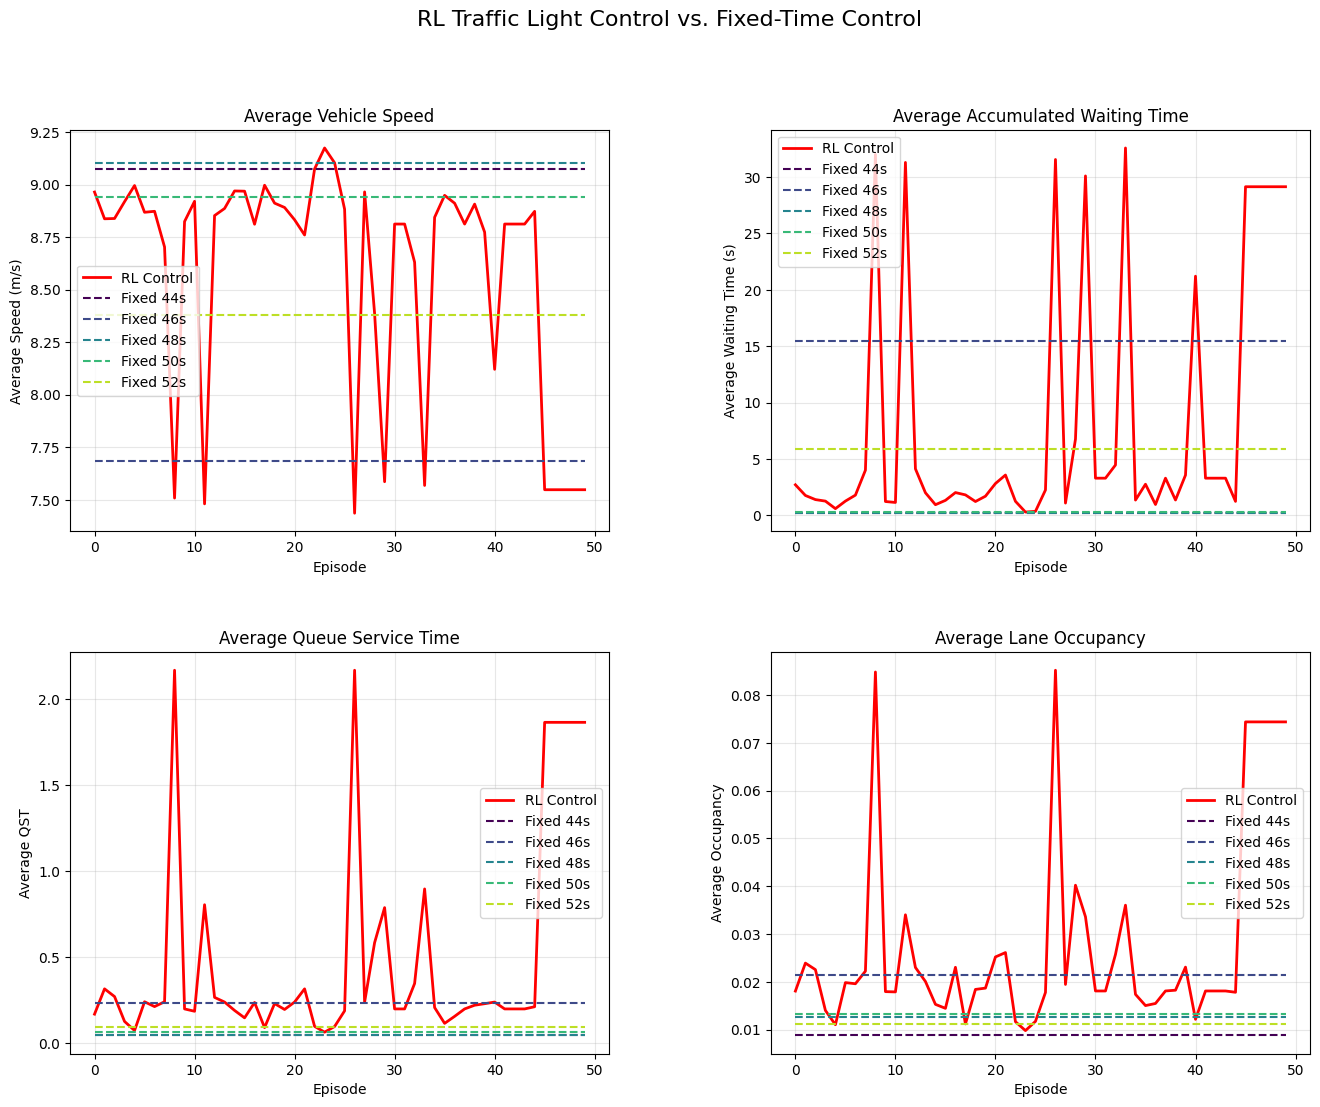

In [116]:
# PERFORMANCE OVER TIME PLOTS
plt.figure(figsize=(16, 12))
gs = GridSpec(2, 2, figure=plt.gcf(), hspace=0.3, wspace=0.3)

# --- 1. Average Speed Plot ---
ax1 = plt.subplot(gs[0, 0])
ax1.plot(rl_avg_speeds_3, label='RL Control', color=rl_color, linewidth=2)
for i, dur in enumerate(fixed_durations3):
    fixed = np.load(f"fixed_metrics_3_{dur}.npy", allow_pickle=True).item()
    ax1.plot([np.mean(fixed['speed'])]*len(rl_avg_speeds_3), '--', label=f'Fixed {dur}s', color=colors[i])
ax1.set_xlabel('Episode')
ax1.set_ylabel('Average Speed (m/s)')
ax1.set_title('Average Vehicle Speed')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# --- 2. Average Waiting Time Plot ---
ax2 = plt.subplot(gs[0, 1])
ax2.plot(rl_avg_waits_3, label='RL Control', color=rl_color, linewidth=2)
for i, dur in enumerate(fixed_durations3):
    fixed = np.load(f"fixed_metrics_3_{dur}.npy", allow_pickle=True).item()
    ax2.plot([np.mean(fixed['acc_wait'])]*len(rl_avg_waits_3), '--', label=f'Fixed {dur}s', color=colors[i])
ax2.set_xlabel('Episode')
ax2.set_ylabel('Average Waiting Time (s)')
ax2.set_title('Average Accumulated Waiting Time')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

# --- 3. Average QST Plot ---
ax3 = plt.subplot(gs[1, 0])
ax3.plot(rl_avg_qsts_3, label='RL Control', color=rl_color, linewidth=2)
for i, dur in enumerate(fixed_durations3):
    fixed = np.load(f"fixed_metrics_3_{dur}.npy", allow_pickle=True).item()
    ax3.plot([np.mean(fixed['qst'])]*len(rl_avg_qsts_3), '--', label=f'Fixed {dur}s', color=colors[i])
ax3.set_xlabel('Episode')
ax3.set_ylabel('Average QST')
ax3.set_title('Average Queue Service Time')
ax3.legend(loc='best')
ax3.grid(True, alpha=0.3)

# --- 4. Average Occupancy Plot ---
ax4 = plt.subplot(gs[1, 1])
ax4.plot(rl_avg_occs_3, label='RL Control', color=rl_color, linewidth=2)
for i, dur in enumerate(fixed_durations3):
    fixed = np.load(f"fixed_metrics_3_{dur}.npy", allow_pickle=True).item()
    ax4.plot([np.mean(fixed['occupancy'])]*len(rl_avg_occs_3), '--', label=f'Fixed {dur}s', color=colors[i])
ax4.set_xlabel('Episode')
ax4.set_ylabel('Average Occupancy')
ax4.set_title('Average Lane Occupancy')
ax4.legend(loc='best')
ax4.grid(True, alpha=0.3)

plt.suptitle('RL Traffic Light Control vs. Fixed-Time Control', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('rl_vs_fixed_comparison_3.png', dpi=300, bbox_inches='tight')
plt.show()

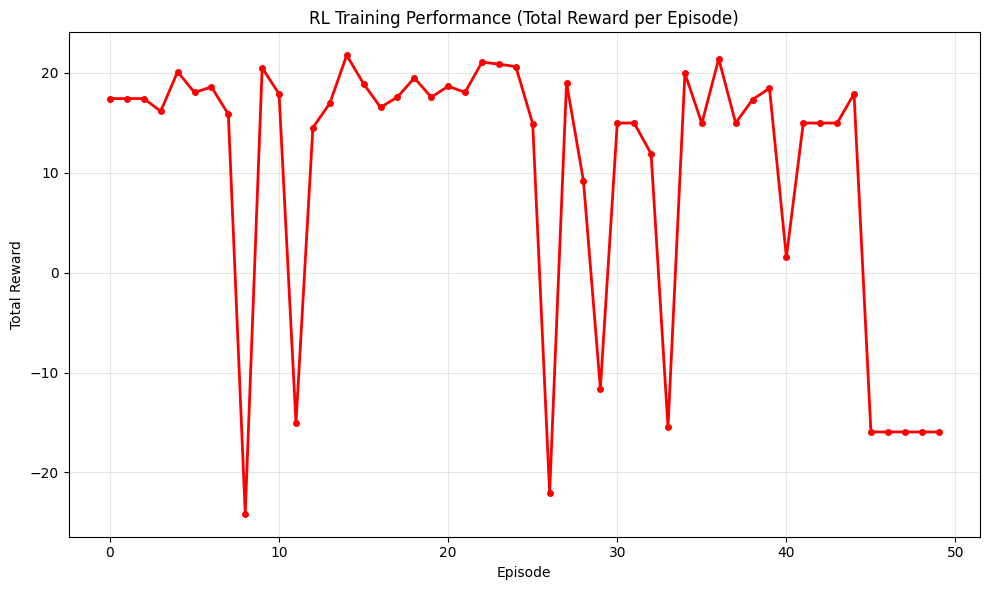

In [117]:
# REWARDS PLOT
plt.figure(figsize=(10, 6))
plt.plot(rl_rewards3, color=rl_color, linewidth=2, marker='o', markersize=4)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('RL Training Performance (Total Reward per Episode)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('rl_rewards_3.png', dpi=300, bbox_inches='tight')
plt.show()

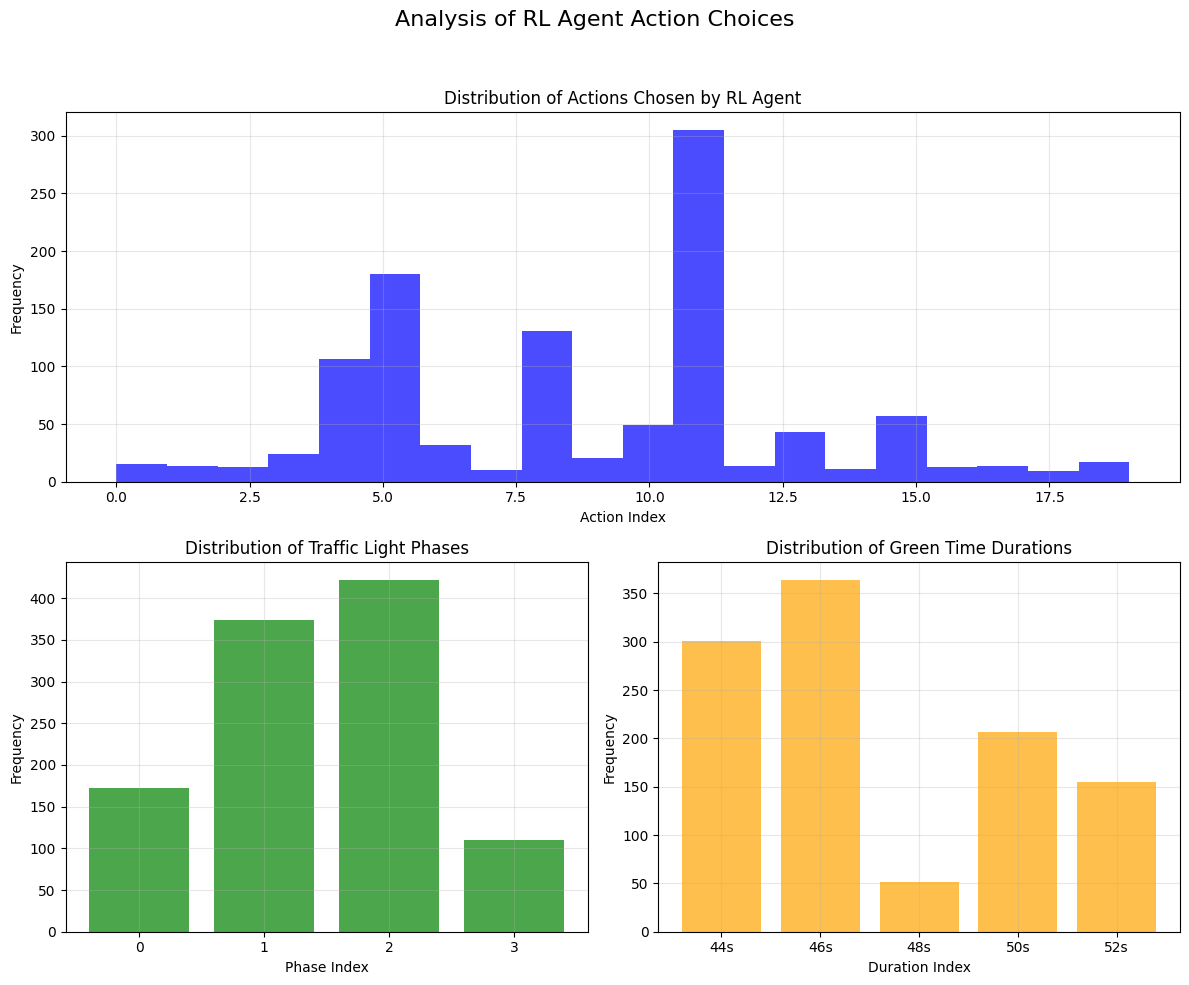

In [118]:
# ACTION DISTRIBUTION ANALYSIS
plt.figure(figsize=(12, 10))

# 1. Action frequency histogram
plt.subplot(2, 1, 1)
plt.hist(actions3, bins=len(phases)*len(durations3), alpha=0.7, color='blue')
plt.xlabel('Action Index')
plt.ylabel('Frequency')
plt.title('Distribution of Actions Chosen by RL Agent')
plt.grid(True, alpha=0.3)

# 2. Phase distribution
phase_indices = [action // len(durations3) for action in actions3]
plt.subplot(2, 2, 3)
phase_counts = np.bincount(phase_indices, minlength=len(phases))
plt.bar(range(len(phases)), phase_counts, alpha=0.7, color='green')
plt.xlabel('Phase Index')
plt.ylabel('Frequency')
plt.title('Distribution of Traffic Light Phases')
plt.xticks(range(len(phases)))
plt.grid(True, alpha=0.3)

# 3. Duration distribution
duration_indices = [action % len(durations3) for action in actions3]
plt.subplot(2, 2, 4)
duration_counts = np.bincount(duration_indices, minlength=len(durations3))
plt.bar(range(len(durations3)), duration_counts, alpha=0.7, color='orange')
plt.xlabel('Duration Index')
plt.ylabel('Frequency')
plt.title('Distribution of Green Time Durations')
plt.xticks(range(len(durations3)), [f"{durations3[i]}s" for i in range(len(durations3))])
plt.grid(True, alpha=0.3)

plt.suptitle('Analysis of RL Agent Action Choices', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('action_distribution_3.png', dpi=300, bbox_inches='tight')
plt.show()

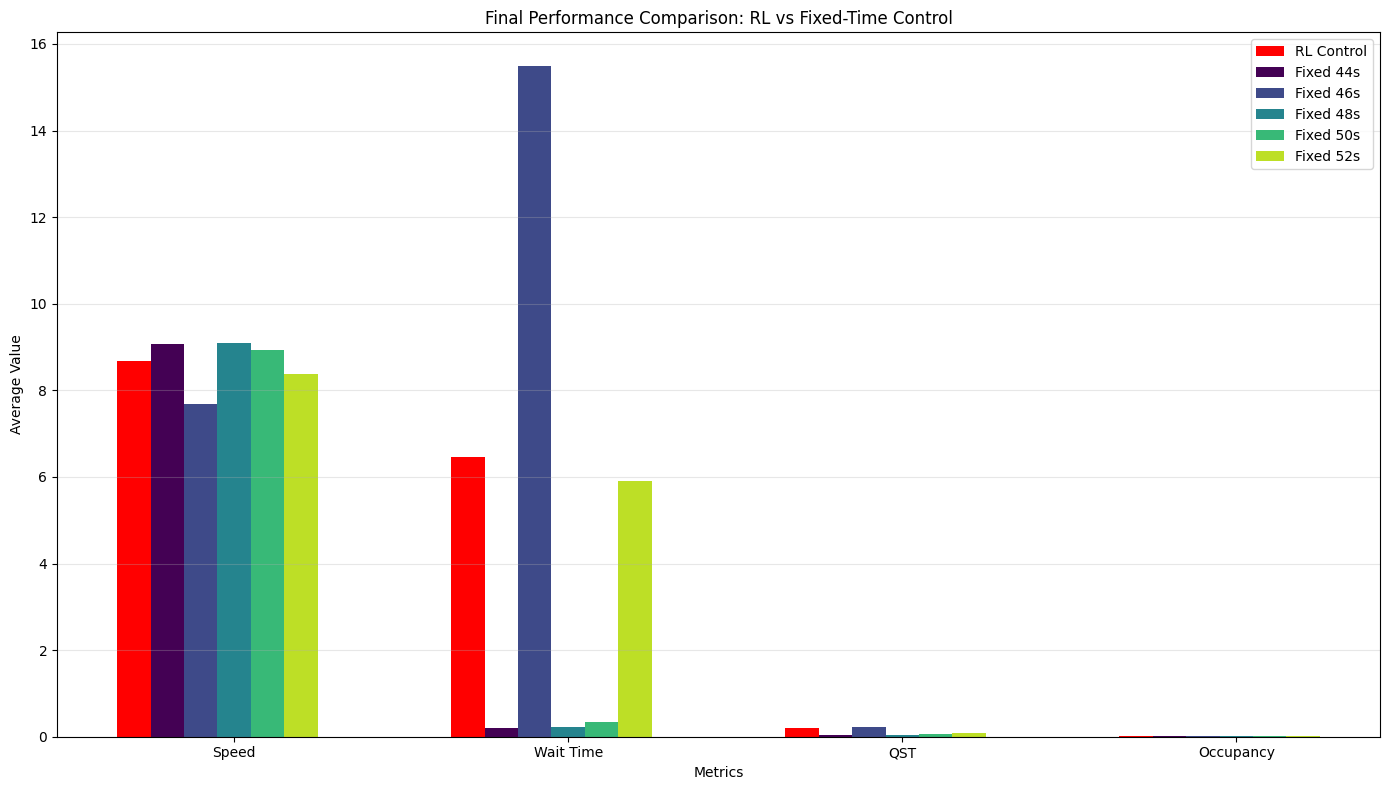

In [120]:
# FINAL PERFORMANCE COMPARISON (Bar Chart)
# Calculate average performance over last 5 episodes 
last_n = 10
final_rl_speed = np.mean(rl_avg_speeds_3[-last_n:-5])
final_rl_wait = np.mean(rl_avg_waits_3[-last_n:-5])
final_rl_qst = np.mean(rl_avg_qsts_3[-last_n:-5])
final_rl_occ = np.mean(rl_avg_occs_3[-last_n:-5])

# Prepare data for bar chart
metrics = ['Speed', 'Wait Time', 'QST', 'Occupancy']
rl_values = [final_rl_speed, final_rl_wait, final_rl_qst, final_rl_occ]
fixed_values = []

for dur in fixed_durations3:
    fixed = np.load(f"fixed_metrics_3_{dur}.npy", allow_pickle=True).item()
    fixed_values.append([
        np.mean(fixed['speed']),
        np.mean(fixed['acc_wait']),
        np.mean(fixed['qst']),
        np.mean(fixed['occupancy'])
    ])

# Create a grouped bar chart
plt.figure(figsize=(14, 8))
bar_width = 0.1
index = np.arange(len(metrics))

# Plot RL bars
plt.bar(index, rl_values, bar_width, label='RL Control', color=rl_color)

# Plot fixed duration bars
for i, dur in enumerate(fixed_durations3):
    plt.bar(index + (i+1)*bar_width, fixed_values[i], bar_width, 
            label=f'Fixed {dur}s', color=colors[i])

plt.xlabel('Metrics')
plt.ylabel('Average Value')
plt.title('Final Performance Comparison: RL vs Fixed-Time Control')
plt.xticks(index + bar_width*3, metrics)
plt.legend(loc='best')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('final_performance_comparison_3.png', dpi=300, bbox_inches='tight')
plt.show()


### Final Conclusion

The RL model performed well in most cases, but underperformed in the final scenario. This indicates that its effectiveness is influenced by the **action space** defined during training. 

From the analysis of three different action space configurations, durations of **42s and 44s** consistently yielded better results. However, to draw more confident conclusions, the model should be trained with a **larger action space** and run over **more episodes**.

It appears that the model was still in its **exploration phase**, so extending the training (e.g., to 4000–4500 episodes) would likely lead to improved performance. Additionally, a **step limit of 1000** was chosen to allow enough time for congestion to build while keeping the simulation computationally efficient.

Interestingly, in GUI-based simulations, peak congestion was observed around **3700s**, reinforcing the need to simulate for longer durations to better capture real traffic behavior.